# Определение стоимости автомобилей

**Описание задачи**    
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

**Признаки**   
`DateCrawled` — дата скачивания анкеты из базы    
`VehicleType` — тип автомобильного кузова    
`RegistrationYear` — год регистрации автомобиля    
`Gearbox` — тип коробки передач    
`Power` — мощность (л. с.)    
`Model` — модель автомобиля    
`Kilometer` — пробег (км)    
`RegistrationMonth` — месяц регистрации автомобиля    
`FuelType` — тип топлива    
`Brand` — марка автомобиля    
`NotRepaired` — была машина в ремонте или нет     
`DateCreated` — дата создания анкеты    
`NumberOfPictures` — количество фотографий автомобиля    
`PostalCode` — почтовый индекс владельца анкеты (пользователя)    
`LastSeen` — дата последней активности пользователя     

**Целевой признак**    
`Price` — цена (евро)

**План работы**

В первую очередь надо изучить данные. Поискать дубликаты, выбросы. Предположить какие признаки не несут полезной информации для целевого признака. 

Потом подготовить данные для ML. 
Для деревянных моделей буду использовать OrdinalEncoder, для остальных попробую OHE

С моделей буду извлекать время обучения, скорость предсказания, и качество на тренировочной выборке. 
После выберу лучшую модель и посмотрю качество на тестовой выборке

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv

plt.style.use('seaborn-darkgrid')
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
shape0 = df.shape #сохраняю размер датафрейма до обработки 
shape0

(354369, 16)

Нам дан датасет на 354369 строк

In [4]:
df.head()  #вывожу первые пять строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Можно заметить, что в датасете присутствуют пропуски. Выведем информацию о Dtype    

In [5]:
df.info()  # вывожу информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
date = ['DateCrawled', 'DateCreated', 'LastSeen'] # изменяю тип данных
df[date] = df[date].astype('datetime64')

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбце `RegistrationYear` видны выбросы в виде года регистрации в 1000 и 9999 лет   
В `power` виднеются значения в виде минимальной мощности в 0 и максимальной 20000    
В `NumbersOfPictures` все значения нулевые. Их можно удалить     
В `RegistrationMonth` дано 13 месяцев? С 0го по 12? Надо проверить    
В `Price` есть минимальная стоимость в виде 0. Посмотрим на целевую переменную в самом конце
    
Так же помимо `NumbersOfPictures` предлагаю удалить    
`DateCrawled` поскольку цена на анкете не будет завизить от даты скачивания её с базы     
`PostalCode` поскольку почтовый индекс владельца не влияет на стоимость автомобиля (хотя тут смелое заявление, региональные цены ведь есть)      
`LastSeen` от последней активности стоимость автомобиля не зависит     

Так же перед удалением лишних столбцов надо провести проверку на явные дубликаты 

In [8]:
df.duplicated().sum()#проверяю датасет на явные дубликаты

4

In [9]:
df.drop_duplicates(inplace = True) #удаляю явные дубликаты 
df.drop(['NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1, inplace = True) #удаляем столбцы

Надо проверить, что бы дата создания анкеты не была позже  года регистрации автомобиля. Идеи как исправить данную ошибку нет. Это критичная ошибка в заполнении данных. Потому предлагаю удалить те строки где создание анкеты происходило раньше регистрации автомобиля

In [10]:
df = df[df['DateCreated'].dt.year >= df['RegistrationYear']]  #удаляем аномальные значение годов 
df.shape # смотрим на размер таблицы 

(339835, 13)

После удаления лишних значений у нас остаётся 339839 строк. Посмотрим на аномалии в `Power` и `RegistrationYear`

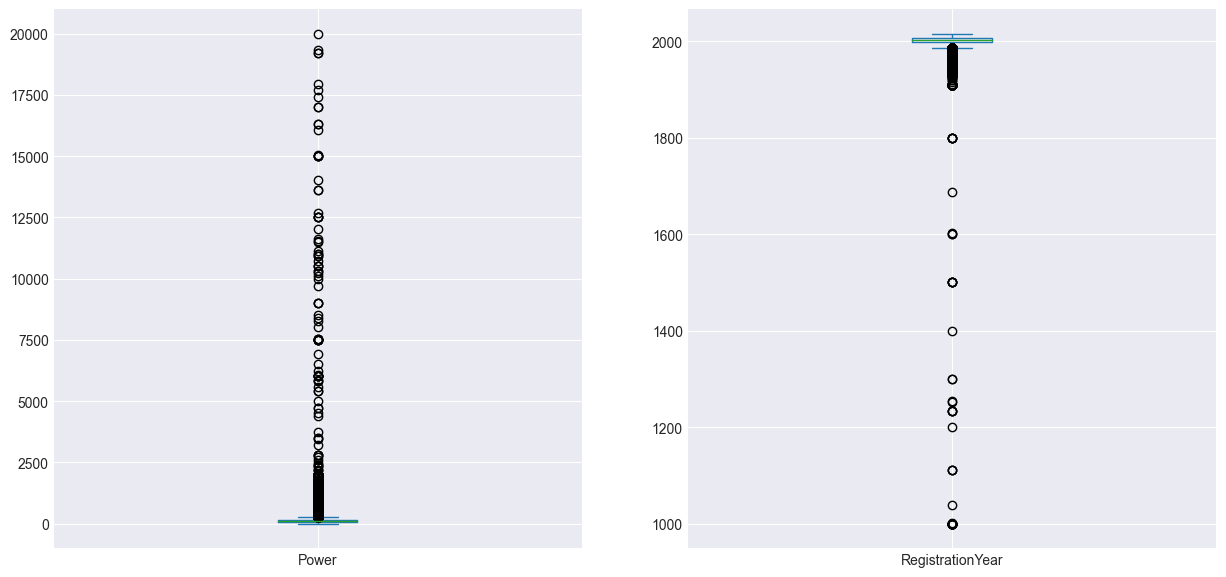

In [11]:
df.loc[:,['Power', 'RegistrationYear']].plot(kind = 'box', figsize = (15, 7), subplots = True);

В `RegistratonYear` предлагаю удалить значения ниже 1 процентиля. Ошибки в данной колонке должны сразу отметаться. Поскольку сомневаюсь, что есть автомобили 1000года производства. Хотя возможно это назад в будущее 4?      
В `Power` посмотрим на корреляцию, что бы решить как будем заменять значения

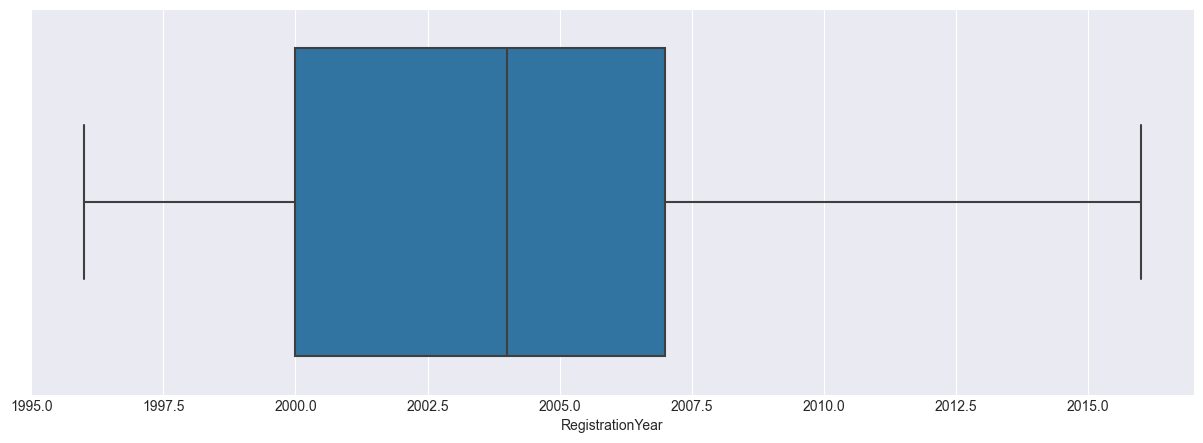

In [12]:
df = df[df['RegistrationYear'] > df['RegistrationYear'].quantile(0.1)]

fig = plt.figure(figsize=(15,5))
sns.boxplot(x = df['RegistrationYear'])
plt.show()

В датасете мы оставили только те машины у которых была дата регистрации от 1995 до 2015 года

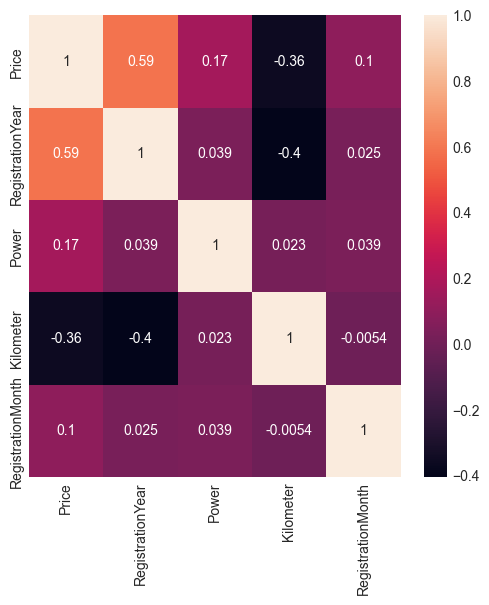

In [13]:
fig = plt.figure(figsize = (6,6))
sns.heatmap(df.corr(), annot = True)
plt.show();

Числовые признаки почти ни как не коррелируют друг с другом.    
Высокое значение только у `RegistrationYear` с `Price`. Возможно наше решение удаление аномалий  была верным решением   
Посмотрим на `Power` повнимательней

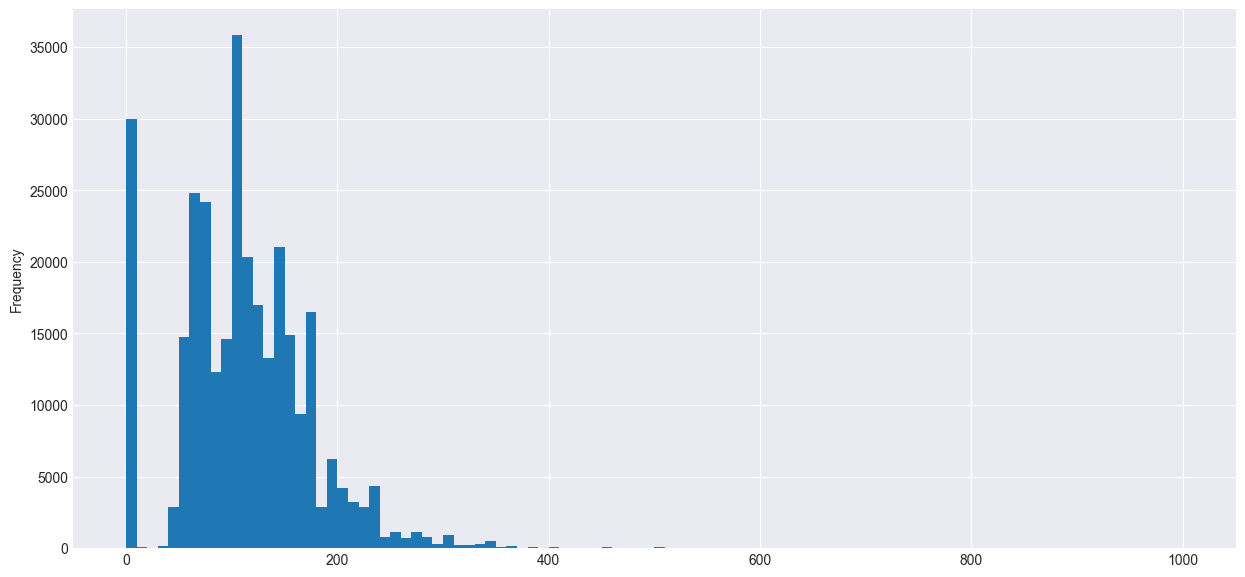

In [14]:
df['Power'].plot(kind =  'hist', bins = 100, figsize = (15,7), grid = True, range = (0, 1000));

Мы наблюдаем много нулевых значений. И очень много выбросов в виде мощности в 1000 лошадинных сил(P.s. это мы ещё ограничили график по оси 0Х) 

In [15]:
df.query('0 < Power < 400', inplace = True) #делаю срез. 

In [16]:
df['RegistrationMonth'].nunique() # проверим теорию о количестве месяцев в месяце регистрации автомобиля 

13

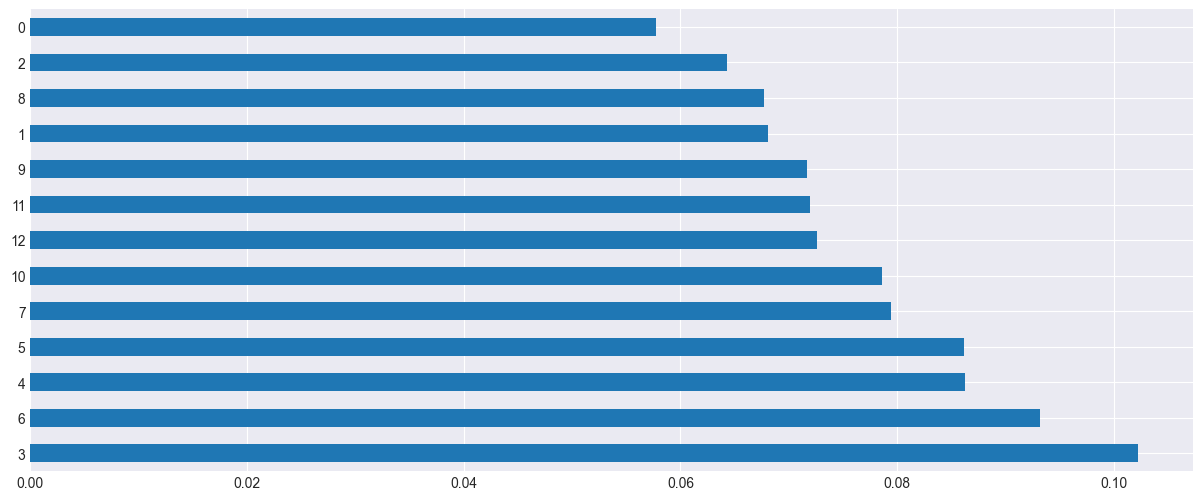

In [17]:
df['RegistrationMonth'].value_counts(normalize = True).plot(kind = 'barh', figsize = (15, 6), grid = True);

Как исправить ошибку в месяце регистрации автомобиля идеи нет. Удалять почти 6% датасета не хочется.    
Потому делаю предположение, что месяц регистрации не сильно влияет на стоимость автомобиля и просто удалю данный столбец

In [18]:
df.drop(['RegistrationMonth'], axis = 1, inplace = True)

Переходим к обработке пропусков

In [19]:
df.isna().mean().to_frame()

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.038798
RegistrationYear,0.000000
Gearbox,0.018067
Power,0.000000
Model,0.035076
Kilometer,0.000000
FuelType,0.051881
Brand,0.000000


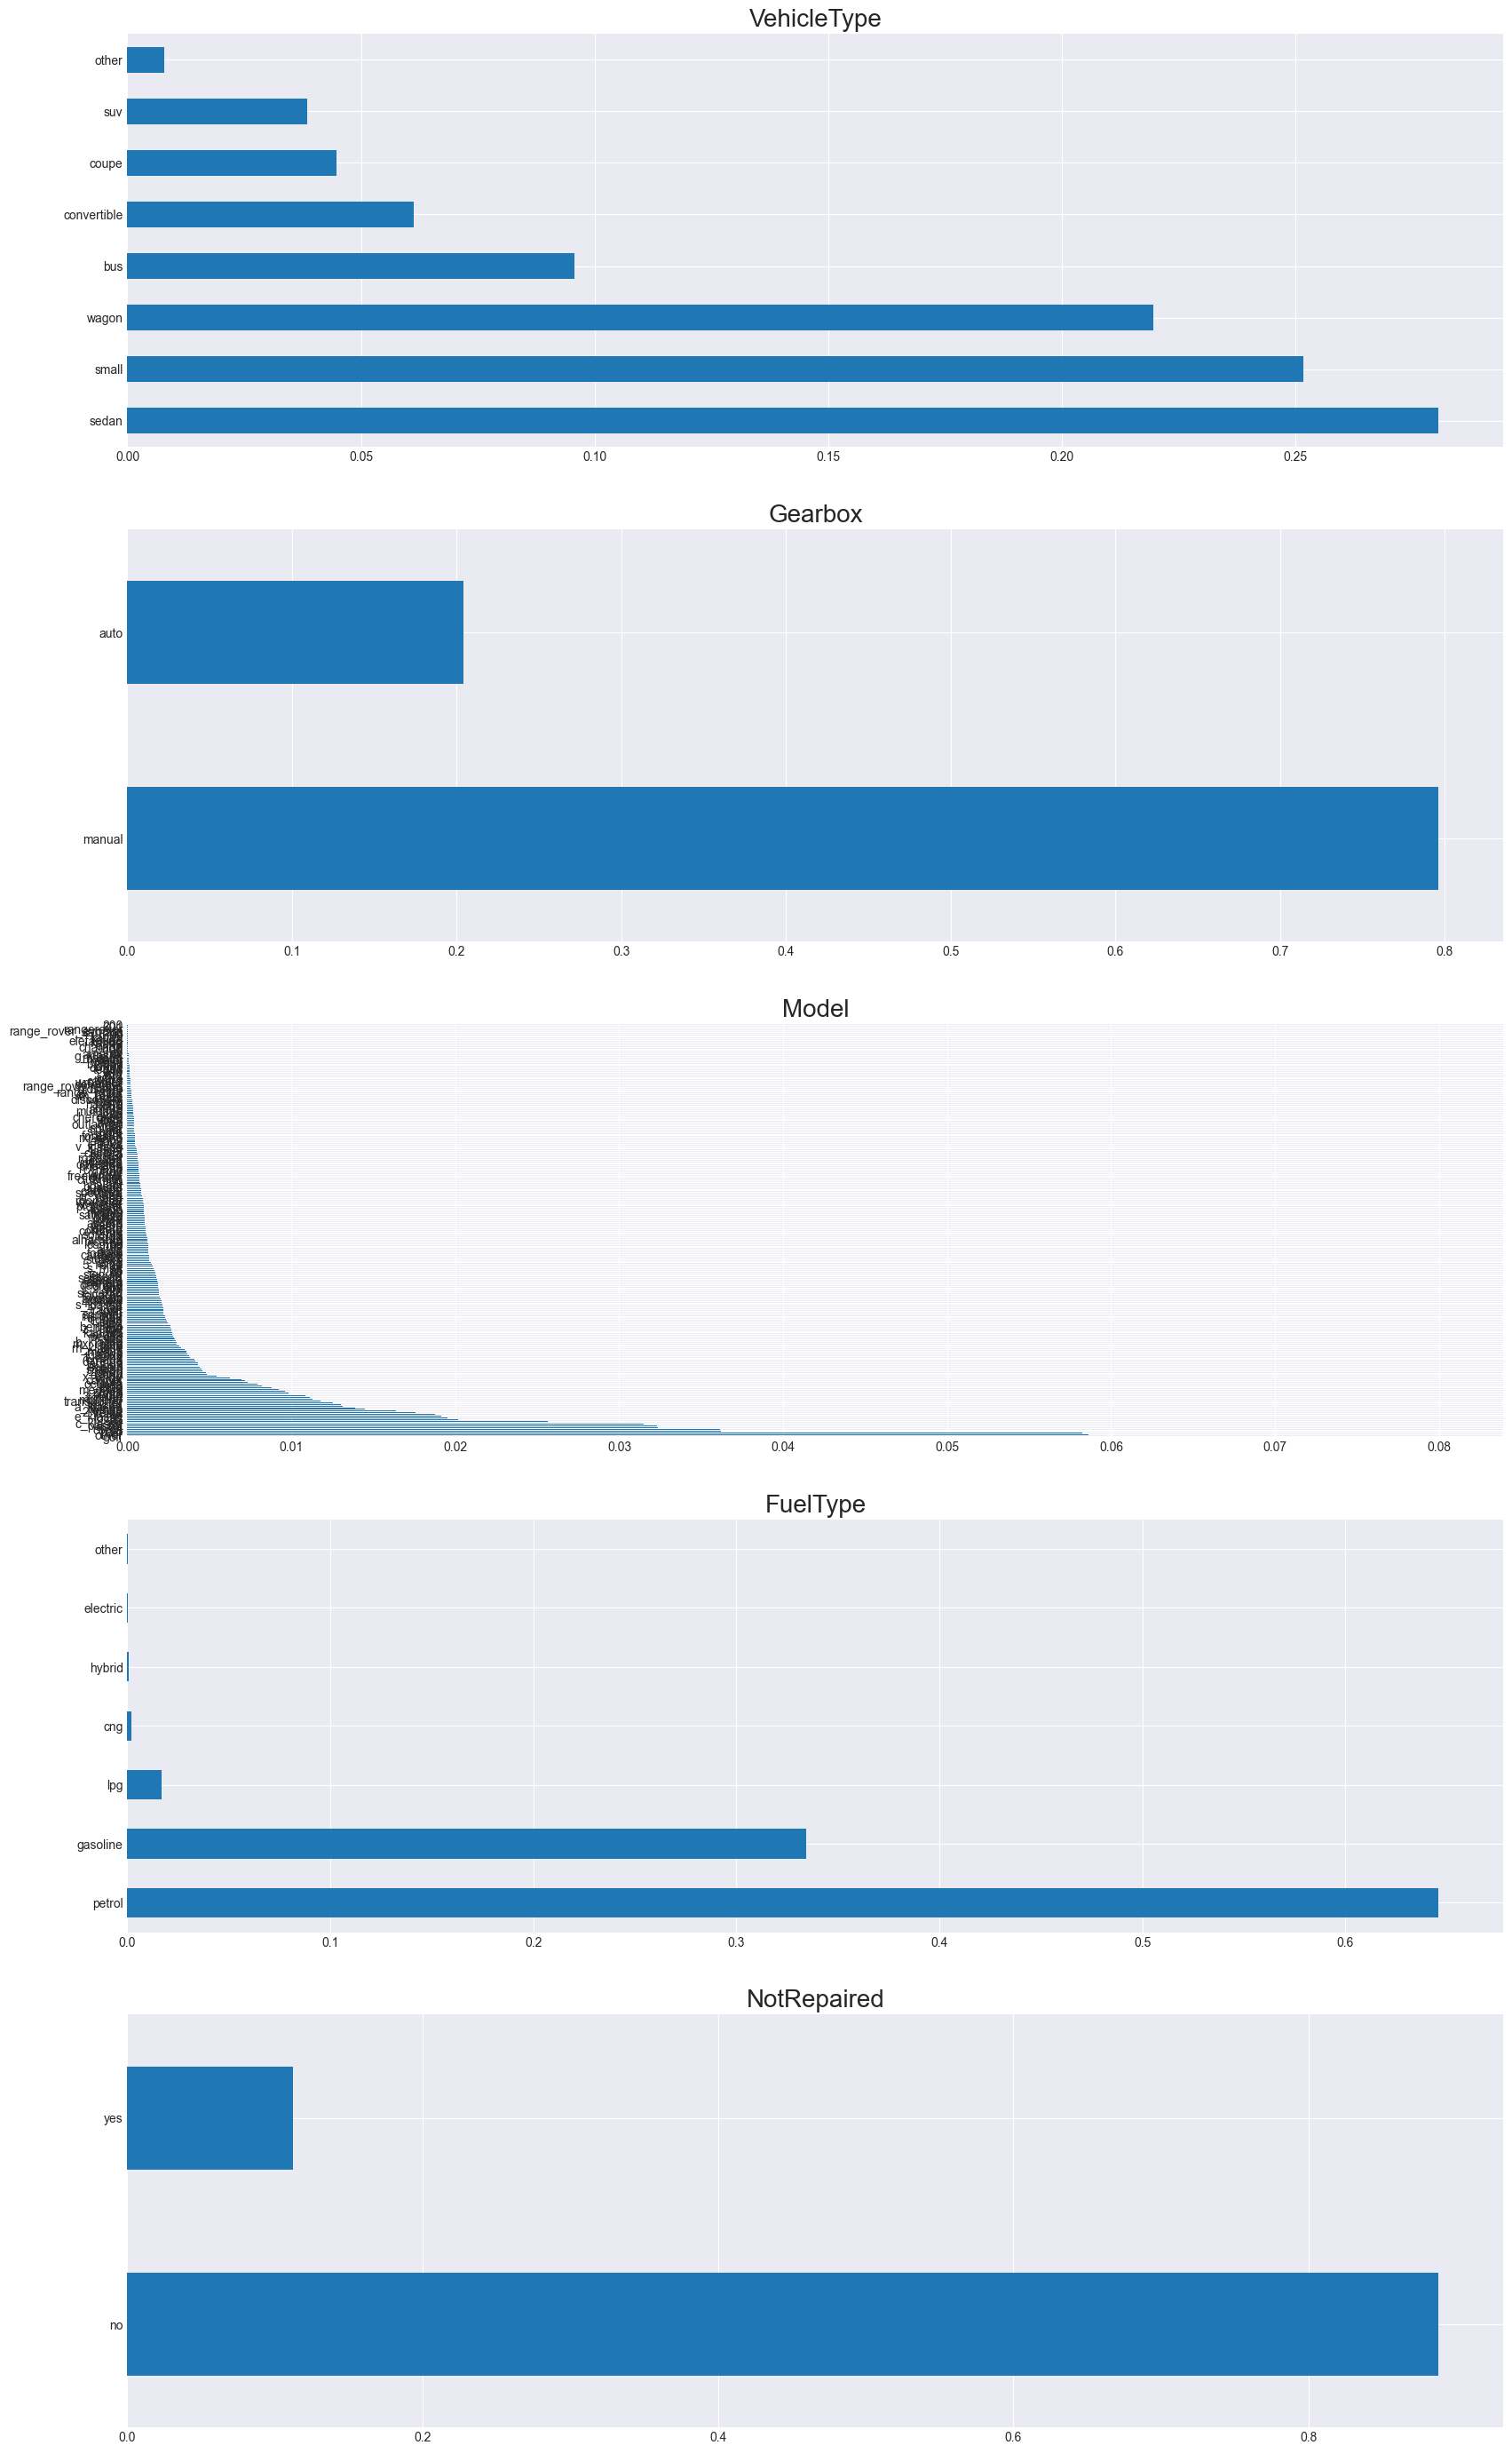

In [20]:
isna = [i for i in df.columns if df[i].isna().sum() != 0]
fig = plt.figure(figsize = (20,35))
for i in range(len(isna)):
    data = df[isna[i]]
    plt.subplot(len(isna), 1, i+1)
    data.value_counts(normalize = True).plot(kind = 'barh')
    plt.title(isna[i], fontdict = {'fontsize' : 20})

Можно было использовать заполнение пропусков модой в некоторых столбцах, поскольку в большинстве столбцов мода составляет более 60%, а значением пропусков менее 4%. 
А в других воспользоваться удалением пропусков.   
Но поскольку пропуски есть в категориальных столбцах я выбрал заполнить пропуски неизвестным

In [21]:
df.loc[:,isna] = df.loc[:,isna].fillna('unknown')

Посмотрим так же на распределение нашего целового значения

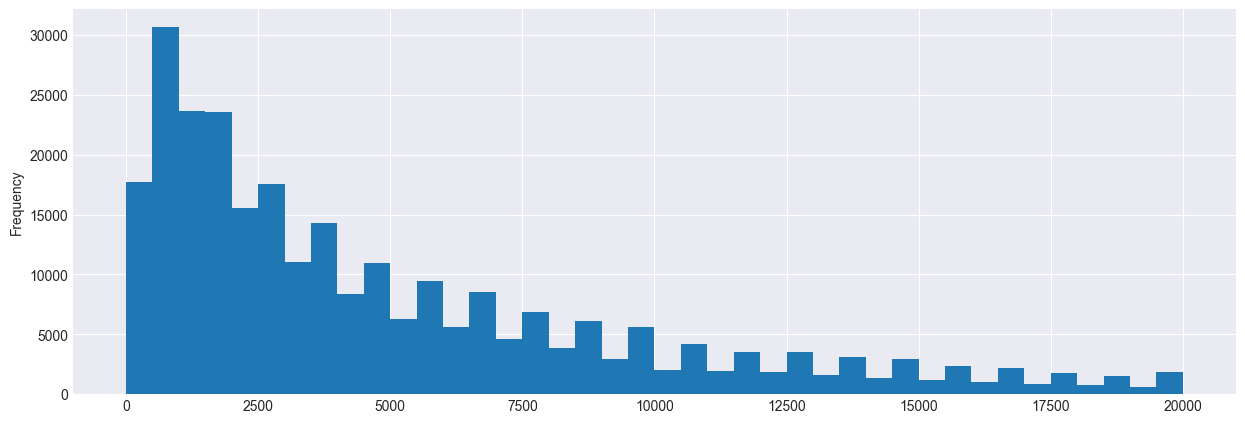

In [22]:
df['Price'].plot(kind = 'hist', bins = 40, figsize = (15,5), grid = True);

Имеется всплеск в районе 0 значения. Далее у нас идёт затухание целевого признака по экспоненте. Предлагаю посмотреть значения около нуля

In [23]:
df.loc[df['Price'] < 10, 'Price'].value_counts()

0    5022
1     509
2       6
5       6
3       4
9       1
Name: Price, dtype: int64

Наблюдаем, что у нас есть всплеск значений 0 и 1. Возможно на сайте нет ограничения в минимальной стоимости автомобиля. И клиенты могут случайно создать заявку указав 0 стоимость 

In [24]:
df.query('Price > 1', inplace = True)

Так же создам дополнительные столбцы с годом, месяц, днём создания анкеты 

In [25]:
df['YearCrawled'] = df['DateCrawled'].dt.year
df['MonthCrawled'] = df['DateCrawled'].dt.month
df['DayCrawled'] = df['DateCrawled'].dt.day
df.drop(['DateCrawled'], axis = 1, inplace = True)

In [26]:
df['YearCreated'] = df['DateCreated'].dt.year
df['MonthCreated'] = df['DateCreated'].dt.month
df['DayCreated'] = df['DateCreated'].dt.day
df.drop(['DateCreated'], axis = 1, inplace = True)

In [27]:
df.reset_index(drop = True, inplace = True) #обновлю значения индексов

In [28]:
shape1 = df.shape
shape1

(267729, 16)

In [29]:
shape0[0] - shape1[0]

86640

В результате обработки было удалено 86640 строк 

**Применение train_test_split**

In [30]:
target = df['Price']
features = df.drop(['Price'], axis = 1)

target_train, target_test, features_train, features_test =  train_test_split(
    target, features, test_size = 0.33, random_state = 83213)

In [31]:
for x,y,z in zip((target_train, target_test),(features_train, features_test), ('тренировочной', 'тестовой')):
    print(f'В {z} выборке, размеры матрицы признаков  = {y.shape}, целевого признака = {x.shape}')

В тренировочной выборке, размеры матрицы признаков  = (179378, 15), целевого признака = (179378,)
В тестовой выборке, размеры матрицы признаков  = (88351, 15), целевого признака = (88351,)


**Кодирование категориальных переменных при помощи OHE** 

In [32]:
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

train_one = features_train.reset_index(drop = True).copy()
test_one = features_test.reset_index(drop = True).copy()

onehot_encoder = OneHotEncoder(sparse = False, drop = 'first', dtype = 'int64')

train_one_cat_cols = pd.DataFrame(onehot_encoder.fit_transform(train_one[cat_cols]))
train_one.drop(cat_cols, axis = 1, inplace = True)
train_one = pd.concat([train_one, train_one_cat_cols], axis = 1)
train_one.rename(columns = lambda x:str(x), inplace = True)

test_one_cat_cols = pd.DataFrame(onehot_encoder.transform(test_one[cat_cols]))
test_one.drop(cat_cols, axis = 1, inplace = True)
test_one = pd.concat([test_one, test_one_cat_cols], axis = 1)
test_one.rename(columns = lambda x:str(x), inplace = True)

**Применение StandardScaler для числовых переменных**

In [33]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'YearCreated', 'MonthCreated', 'DayCreated', 'YearCreated', 
            'MonthCreated', 'DayCreated']

scaler = StandardScaler()
scaler.fit(train_one[num_cols])

train_one[num_cols] = scaler.transform(train_one[num_cols])
test_one[num_cols] = scaler.transform(test_one[num_cols])

## Обучение моделей

Для обучения модели использую метрику rmse

In [34]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions)**0.5

scorer = make_scorer(rmse, greater_is_better=False)

In [35]:
def model_training(model, parametrs, x_train = train_one, y_train = target_train):
    grid = GridSearchCV(model, parametrs, cv = 5, scoring=scorer, verbose = 5)
    grid.fit(x_train, y_train)  
    print(grid.best_estimator_)
    
    ml = grid.best_estimator_  #отбираем наилучшие параметры при помощи GridSearchCV    
    
    start1 = time.time()
    ml.fit(x_train, y_train)
    finish1 = time.time() - start1
    print('Время обучения на тренировочной выборке составило ', finish1)
    
    start2 = time.time()
    predict =  ml.predict(x_train)
    finish2 = time.time() - start2
    print('Время предсказания на тренировочной выборке составило ', finish2)
    
    print('оценка RMSE на кросс валидации = ', -(grid.best_score_))
    
    return -(grid.best_score_), finish1, finish2  

**Линейная регрессия**

In [36]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False]}

score, finish1, finish2 = model_training(model, parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ............fit_intercept=True;, score=-2237.613 total time=   8.8s
[CV 2/5] END ............fit_intercept=True;, score=-2201.348 total time=   6.1s
[CV 3/5] END .......fit_intercept=True;, score=-396195732.658 total time=   6.1s
[CV 4/5] END ............fit_intercept=True;, score=-2225.837 total time=   6.2s
[CV 5/5] END ............fit_intercept=True;, score=-2198.189 total time=   6.6s
[CV 1/5] END ...........fit_intercept=False;, score=-2237.447 total time=   6.1s
[CV 2/5] END ...........fit_intercept=False;, score=-2201.348 total time=   5.8s
[CV 3/5] END ...........fit_intercept=False;, score=-2227.948 total time=   6.0s
[CV 4/5] END ...........fit_intercept=False;, score=-2225.837 total time=   6.1s
[CV 5/5] END ...........fit_intercept=False;, score=-2198.333 total time=   6.1s
LinearRegression(fit_intercept=False)
Время обучения на тренировочной выборке составило  7.608137369155884
Время предсказания на т

In [37]:
result = pd.DataFrame({'модель':['Линейная регрессия'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.18269,7.608137,0.317001


**Градиентный бустинг**

In [38]:
model = GradientBoostingRegressor(random_state= 46754)
parameters = {'n_estimators': range (50, 81, 10), 'max_depth': range (3,5)}

score, finish1, finish2 = model_training(model, parameters)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..max_depth=3, n_estimators=50;, score=-1966.334 total time=  48.8s
[CV 2/5] END ..max_depth=3, n_estimators=50;, score=-1909.656 total time=  47.6s
[CV 3/5] END ..max_depth=3, n_estimators=50;, score=-1956.363 total time=  44.5s
[CV 4/5] END ..max_depth=3, n_estimators=50;, score=-1966.307 total time=  44.0s
[CV 5/5] END ..max_depth=3, n_estimators=50;, score=-1926.571 total time=  43.6s
[CV 1/5] END ..max_depth=3, n_estimators=60;, score=-1916.551 total time=  52.5s
[CV 2/5] END ..max_depth=3, n_estimators=60;, score=-1858.975 total time=  55.6s
[CV 3/5] END ..max_depth=3, n_estimators=60;, score=-1906.247 total time=  54.1s
[CV 4/5] END ..max_depth=3, n_estimators=60;, score=-1919.945 total time=  53.4s
[CV 5/5] END ..max_depth=3, n_estimators=60;, score=-1875.736 total time=  55.0s
[CV 1/5] END ..max_depth=3, n_estimators=70;, score=-1881.605 total time= 1.1min
[CV 2/5] END ..max_depth=3, n_estimators=70;, sco

In [39]:
result1 = pd.DataFrame({'модель':['Градиентный бустинг'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,7.608137,0.317001
1,Градиентный бустинг,1729.870244,110.480458,1.202637


**LightGBM**

In [40]:
model = LGBMRegressor(random_state=45648741)
parametrs = {'n_estimators': range(100,131, 10), 'num_leaves': range(31,42,10)}

score, finish1, finish2 = model_training(model, parametrs)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END n_estimators=100, num_leaves=31;, score=-1603.312 total time=   2.1s
[CV 2/5] END n_estimators=100, num_leaves=31;, score=-1562.505 total time=   1.9s
[CV 3/5] END n_estimators=100, num_leaves=31;, score=-1586.476 total time=   1.8s
[CV 4/5] END n_estimators=100, num_leaves=31;, score=-1604.572 total time=   1.9s
[CV 5/5] END n_estimators=100, num_leaves=31;, score=-1554.592 total time=   1.9s
[CV 1/5] END n_estimators=100, num_leaves=41;, score=-1580.778 total time=   1.9s
[CV 2/5] END n_estimators=100, num_leaves=41;, score=-1541.459 total time=   1.9s
[CV 3/5] END n_estimators=100, num_leaves=41;, score=-1565.499 total time=   2.0s
[CV 4/5] END n_estimators=100, num_leaves=41;, score=-1583.212 total time=   2.0s
[CV 5/5] END n_estimators=100, num_leaves=41;, score=-1530.415 total time=   2.0s
[CV 1/5] END n_estimators=110, num_leaves=31;, score=-1595.513 total time=   1.9s
[CV 2/5] END n_estimators=110, num_lea

In [41]:
result1 = pd.DataFrame({'модель':['LightGBM'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,7.608137,0.317001
1,Градиентный бустинг,1729.870244,110.480458,1.202637
2,LightGBM,1542.058381,2.447164,1.420220


**Catboost**

In [42]:
encoder = OrdinalEncoder()

ordinal_train = features_train.reset_index(drop=True).copy()
ordinal_train[cat_cols] = encoder.fit_transform(ordinal_train[cat_cols])

ordinal_test = features_test.reset_index(drop=True).copy()
ordinal_test[cat_cols] = encoder.transform(ordinal_test[cat_cols])

In [43]:
model = CatBoostRegressor(random_state=234)
parametrs = {'depth': [4,5],
             'learning_rate' : [0.01,0.02]}

grid = GridSearchCV(model, parametrs, cv = 3, scoring=scorer, verbose = False)
grid.fit(ordinal_train, target_train)

0:	learn: 4604.2633256	total: 167ms	remaining: 2m 46s
1:	learn: 4575.3861510	total: 176ms	remaining: 1m 27s
2:	learn: 4547.5062649	total: 185ms	remaining: 1m 1s
3:	learn: 4519.7740275	total: 193ms	remaining: 48.1s
4:	learn: 4492.8850270	total: 202ms	remaining: 40.2s
5:	learn: 4466.3400301	total: 210ms	remaining: 34.9s
6:	learn: 4439.7554713	total: 219ms	remaining: 31.1s
7:	learn: 4413.5940977	total: 228ms	remaining: 28.2s
8:	learn: 4387.9539419	total: 236ms	remaining: 26s
9:	learn: 4362.3782888	total: 245ms	remaining: 24.2s
10:	learn: 4337.1082615	total: 253ms	remaining: 22.7s
11:	learn: 4312.6195662	total: 261ms	remaining: 21.5s
12:	learn: 4287.1783134	total: 270ms	remaining: 20.5s
13:	learn: 4262.0596780	total: 278ms	remaining: 19.6s
14:	learn: 4237.2430643	total: 287ms	remaining: 18.8s
15:	learn: 4213.7101167	total: 296ms	remaining: 18.2s
16:	learn: 4189.3898247	total: 304ms	remaining: 17.6s
17:	learn: 4165.9762607	total: 313ms	remaining: 17.1s
18:	learn: 4143.0415472	total: 321ms	r

171:	learn: 2459.5752973	total: 1.72s	remaining: 8.3s
172:	learn: 2455.5836125	total: 1.73s	remaining: 8.28s
173:	learn: 2451.5243789	total: 1.74s	remaining: 8.27s
174:	learn: 2447.6923115	total: 1.75s	remaining: 8.26s
175:	learn: 2443.7849224	total: 1.76s	remaining: 8.24s
176:	learn: 2439.7580840	total: 1.77s	remaining: 8.22s
177:	learn: 2435.9298014	total: 1.78s	remaining: 8.2s
178:	learn: 2432.3116256	total: 1.78s	remaining: 8.19s
179:	learn: 2428.5619452	total: 1.79s	remaining: 8.17s
180:	learn: 2424.9394305	total: 1.8s	remaining: 8.15s
181:	learn: 2421.4248666	total: 1.81s	remaining: 8.13s
182:	learn: 2417.8113848	total: 1.82s	remaining: 8.11s
183:	learn: 2414.1272792	total: 1.82s	remaining: 8.09s
184:	learn: 2410.3797036	total: 1.83s	remaining: 8.08s
185:	learn: 2406.9913851	total: 1.84s	remaining: 8.06s
186:	learn: 2403.5905562	total: 1.85s	remaining: 8.04s
187:	learn: 2399.9627830	total: 1.86s	remaining: 8.03s
188:	learn: 2396.4546983	total: 1.87s	remaining: 8.01s
189:	learn: 2

337:	learn: 2093.6553060	total: 3.1s	remaining: 6.08s
338:	learn: 2092.4617871	total: 3.11s	remaining: 6.07s
339:	learn: 2091.2971048	total: 3.12s	remaining: 6.06s
340:	learn: 2090.1953535	total: 3.13s	remaining: 6.05s
341:	learn: 2089.0794002	total: 3.14s	remaining: 6.04s
342:	learn: 2087.8735033	total: 3.15s	remaining: 6.03s
343:	learn: 2086.8707871	total: 3.16s	remaining: 6.02s
344:	learn: 2085.6926128	total: 3.17s	remaining: 6.01s
345:	learn: 2084.6122248	total: 3.17s	remaining: 6s
346:	learn: 2083.4960981	total: 3.18s	remaining: 5.99s
347:	learn: 2082.1237941	total: 3.19s	remaining: 5.97s
348:	learn: 2080.8692113	total: 3.2s	remaining: 5.96s
349:	learn: 2079.8057027	total: 3.21s	remaining: 5.95s
350:	learn: 2078.6793204	total: 3.21s	remaining: 5.94s
351:	learn: 2077.5911435	total: 3.22s	remaining: 5.93s
352:	learn: 2076.5641107	total: 3.23s	remaining: 5.92s
353:	learn: 2075.6410308	total: 3.24s	remaining: 5.91s
354:	learn: 2074.5657933	total: 3.25s	remaining: 5.9s
355:	learn: 2073

498:	learn: 1958.5411621	total: 4.45s	remaining: 4.47s
499:	learn: 1958.0035879	total: 4.46s	remaining: 4.46s
500:	learn: 1957.4501925	total: 4.47s	remaining: 4.45s
501:	learn: 1956.8365414	total: 4.48s	remaining: 4.44s
502:	learn: 1956.1070540	total: 4.49s	remaining: 4.43s
503:	learn: 1955.6415818	total: 4.49s	remaining: 4.42s
504:	learn: 1955.0367214	total: 4.5s	remaining: 4.41s
505:	learn: 1954.4827666	total: 4.51s	remaining: 4.4s
506:	learn: 1953.9288978	total: 4.52s	remaining: 4.39s
507:	learn: 1953.3169675	total: 4.53s	remaining: 4.38s
508:	learn: 1952.5456403	total: 4.53s	remaining: 4.37s
509:	learn: 1952.0594926	total: 4.54s	remaining: 4.36s
510:	learn: 1951.3029193	total: 4.55s	remaining: 4.35s
511:	learn: 1950.8674216	total: 4.56s	remaining: 4.34s
512:	learn: 1950.1259209	total: 4.57s	remaining: 4.33s
513:	learn: 1949.6180120	total: 4.57s	remaining: 4.33s
514:	learn: 1949.1502072	total: 4.58s	remaining: 4.32s
515:	learn: 1948.4236217	total: 4.59s	remaining: 4.3s
516:	learn: 1

662:	learn: 1882.1649358	total: 5.83s	remaining: 2.96s
663:	learn: 1881.8612498	total: 5.84s	remaining: 2.95s
664:	learn: 1881.6165216	total: 5.85s	remaining: 2.94s
665:	learn: 1881.2201173	total: 5.86s	remaining: 2.94s
666:	learn: 1880.6609828	total: 5.87s	remaining: 2.93s
667:	learn: 1880.3432139	total: 5.87s	remaining: 2.92s
668:	learn: 1879.9475611	total: 5.88s	remaining: 2.91s
669:	learn: 1879.5343345	total: 5.89s	remaining: 2.9s
670:	learn: 1879.2504581	total: 5.9s	remaining: 2.89s
671:	learn: 1878.9617444	total: 5.91s	remaining: 2.88s
672:	learn: 1878.5754620	total: 5.91s	remaining: 2.87s
673:	learn: 1878.2113615	total: 5.92s	remaining: 2.86s
674:	learn: 1877.6713129	total: 5.93s	remaining: 2.85s
675:	learn: 1877.3237316	total: 5.94s	remaining: 2.85s
676:	learn: 1877.0273990	total: 5.95s	remaining: 2.84s
677:	learn: 1876.7814191	total: 5.96s	remaining: 2.83s
678:	learn: 1876.3674532	total: 5.96s	remaining: 2.82s
679:	learn: 1876.0615263	total: 5.97s	remaining: 2.81s
680:	learn: 

828:	learn: 1833.7467856	total: 7.2s	remaining: 1.49s
829:	learn: 1833.4486169	total: 7.21s	remaining: 1.48s
830:	learn: 1833.0496557	total: 7.22s	remaining: 1.47s
831:	learn: 1832.8425166	total: 7.23s	remaining: 1.46s
832:	learn: 1832.5342516	total: 7.24s	remaining: 1.45s
833:	learn: 1832.4052262	total: 7.25s	remaining: 1.44s
834:	learn: 1832.0912351	total: 7.26s	remaining: 1.43s
835:	learn: 1831.8613026	total: 7.26s	remaining: 1.43s
836:	learn: 1831.6369167	total: 7.27s	remaining: 1.42s
837:	learn: 1831.4318379	total: 7.28s	remaining: 1.41s
838:	learn: 1831.1937816	total: 7.29s	remaining: 1.4s
839:	learn: 1830.9167825	total: 7.29s	remaining: 1.39s
840:	learn: 1830.6590598	total: 7.3s	remaining: 1.38s
841:	learn: 1830.5291558	total: 7.31s	remaining: 1.37s
842:	learn: 1830.3001399	total: 7.32s	remaining: 1.36s
843:	learn: 1830.0229958	total: 7.33s	remaining: 1.35s
844:	learn: 1829.8702328	total: 7.34s	remaining: 1.34s
845:	learn: 1829.5952002	total: 7.34s	remaining: 1.34s
846:	learn: 1

994:	learn: 1800.3467661	total: 8.57s	remaining: 43.1ms
995:	learn: 1800.1213840	total: 8.58s	remaining: 34.4ms
996:	learn: 1799.9610765	total: 8.59s	remaining: 25.8ms
997:	learn: 1799.8115864	total: 8.59s	remaining: 17.2ms
998:	learn: 1799.5891782	total: 8.6s	remaining: 8.61ms
999:	learn: 1799.4438686	total: 8.61s	remaining: 0us
0:	learn: 4610.4064782	total: 13.3ms	remaining: 13.3s
1:	learn: 4581.4808485	total: 26ms	remaining: 13s
2:	learn: 4553.5417799	total: 36.5ms	remaining: 12.1s
3:	learn: 4525.8005867	total: 46.3ms	remaining: 11.5s
4:	learn: 4498.7356785	total: 57.1ms	remaining: 11.4s
5:	learn: 4472.1845022	total: 66.3ms	remaining: 11s
6:	learn: 4445.6705423	total: 76ms	remaining: 10.8s
7:	learn: 4419.4870432	total: 85.5ms	remaining: 10.6s
8:	learn: 4393.7306776	total: 97.2ms	remaining: 10.7s
9:	learn: 4368.0690395	total: 107ms	remaining: 10.6s
10:	learn: 4342.8288331	total: 117ms	remaining: 10.5s
11:	learn: 4318.2121792	total: 127ms	remaining: 10.5s
12:	learn: 4292.7547144	total

156:	learn: 2520.2382484	total: 1.65s	remaining: 8.85s
157:	learn: 2515.6688739	total: 1.66s	remaining: 8.83s
158:	learn: 2510.8452405	total: 1.67s	remaining: 8.82s
159:	learn: 2506.4946798	total: 1.68s	remaining: 8.8s
160:	learn: 2502.0977724	total: 1.69s	remaining: 8.79s
161:	learn: 2497.4271233	total: 1.7s	remaining: 8.78s
162:	learn: 2492.7699133	total: 1.71s	remaining: 8.78s
163:	learn: 2488.2265407	total: 1.72s	remaining: 8.77s
164:	learn: 2483.7474521	total: 1.73s	remaining: 8.77s
165:	learn: 2479.5513790	total: 1.74s	remaining: 8.76s
166:	learn: 2475.3423006	total: 1.75s	remaining: 8.74s
167:	learn: 2471.2369455	total: 1.76s	remaining: 8.72s
168:	learn: 2466.9108268	total: 1.77s	remaining: 8.7s
169:	learn: 2462.6775552	total: 1.78s	remaining: 8.67s
170:	learn: 2458.4802964	total: 1.78s	remaining: 8.66s
171:	learn: 2454.4685378	total: 1.79s	remaining: 8.64s
172:	learn: 2450.4611122	total: 1.81s	remaining: 8.63s
173:	learn: 2446.4891896	total: 1.81s	remaining: 8.62s
174:	learn: 2

317:	learn: 2113.6037124	total: 3.11s	remaining: 6.67s
318:	learn: 2112.5391884	total: 3.12s	remaining: 6.67s
319:	learn: 2111.2445616	total: 3.13s	remaining: 6.66s
320:	learn: 2110.2014743	total: 3.14s	remaining: 6.65s
321:	learn: 2108.7401621	total: 3.15s	remaining: 6.63s
322:	learn: 2107.5622455	total: 3.16s	remaining: 6.62s
323:	learn: 2106.2504931	total: 3.17s	remaining: 6.61s
324:	learn: 2105.0630767	total: 3.17s	remaining: 6.59s
325:	learn: 2103.9003625	total: 3.18s	remaining: 6.58s
326:	learn: 2102.5444276	total: 3.19s	remaining: 6.57s
327:	learn: 2101.2453235	total: 3.2s	remaining: 6.56s
328:	learn: 2100.0615700	total: 3.22s	remaining: 6.56s
329:	learn: 2098.6891634	total: 3.23s	remaining: 6.55s
330:	learn: 2097.4424875	total: 3.23s	remaining: 6.54s
331:	learn: 2096.1408106	total: 3.24s	remaining: 6.52s
332:	learn: 2094.8483323	total: 3.25s	remaining: 6.51s
333:	learn: 2093.7323255	total: 3.26s	remaining: 6.5s
334:	learn: 2092.5865505	total: 3.27s	remaining: 6.49s
335:	learn: 

481:	learn: 1967.8069024	total: 4.57s	remaining: 4.91s
482:	learn: 1967.1547932	total: 4.58s	remaining: 4.9s
483:	learn: 1966.3667139	total: 4.59s	remaining: 4.89s
484:	learn: 1965.6009348	total: 4.6s	remaining: 4.88s
485:	learn: 1964.8818795	total: 4.61s	remaining: 4.87s
486:	learn: 1964.2471846	total: 4.62s	remaining: 4.86s
487:	learn: 1963.6308673	total: 4.62s	remaining: 4.85s
488:	learn: 1962.9801886	total: 4.63s	remaining: 4.84s
489:	learn: 1962.5096372	total: 4.64s	remaining: 4.83s
490:	learn: 1961.9677055	total: 4.65s	remaining: 4.82s
491:	learn: 1961.1152499	total: 4.66s	remaining: 4.81s
492:	learn: 1960.5702994	total: 4.67s	remaining: 4.8s
493:	learn: 1960.0918674	total: 4.67s	remaining: 4.79s
494:	learn: 1959.4404060	total: 4.68s	remaining: 4.78s
495:	learn: 1958.9044749	total: 4.69s	remaining: 4.76s
496:	learn: 1958.3550976	total: 4.7s	remaining: 4.75s
497:	learn: 1957.5554929	total: 4.71s	remaining: 4.74s
498:	learn: 1957.0720953	total: 4.71s	remaining: 4.73s
499:	learn: 19

648:	learn: 1886.8097722	total: 6.12s	remaining: 3.31s
649:	learn: 1886.3070715	total: 6.13s	remaining: 3.3s
650:	learn: 1885.8455999	total: 6.14s	remaining: 3.29s
651:	learn: 1885.5177762	total: 6.16s	remaining: 3.29s
652:	learn: 1885.1869877	total: 6.17s	remaining: 3.28s
653:	learn: 1884.8481389	total: 6.18s	remaining: 3.27s
654:	learn: 1884.4685153	total: 6.18s	remaining: 3.26s
655:	learn: 1884.1211908	total: 6.19s	remaining: 3.25s
656:	learn: 1883.8929819	total: 6.2s	remaining: 3.24s
657:	learn: 1883.5957714	total: 6.21s	remaining: 3.23s
658:	learn: 1882.9788740	total: 6.22s	remaining: 3.22s
659:	learn: 1882.6062214	total: 6.23s	remaining: 3.21s
660:	learn: 1882.1032901	total: 6.24s	remaining: 3.2s
661:	learn: 1881.8088569	total: 6.25s	remaining: 3.19s
662:	learn: 1881.5221261	total: 6.26s	remaining: 3.18s
663:	learn: 1881.1135468	total: 6.27s	remaining: 3.17s
664:	learn: 1880.8709009	total: 6.28s	remaining: 3.16s
665:	learn: 1880.5965473	total: 6.29s	remaining: 3.15s
666:	learn: 1

805:	learn: 1839.2337246	total: 7.48s	remaining: 1.8s
806:	learn: 1839.1284497	total: 7.49s	remaining: 1.79s
807:	learn: 1838.9258758	total: 7.5s	remaining: 1.78s
808:	learn: 1838.6342418	total: 7.52s	remaining: 1.77s
809:	learn: 1838.4278468	total: 7.53s	remaining: 1.77s
810:	learn: 1838.1043224	total: 7.54s	remaining: 1.76s
811:	learn: 1837.8664964	total: 7.55s	remaining: 1.75s
812:	learn: 1837.6098746	total: 7.56s	remaining: 1.74s
813:	learn: 1837.3171900	total: 7.57s	remaining: 1.73s
814:	learn: 1837.1517766	total: 7.57s	remaining: 1.72s
815:	learn: 1836.9218096	total: 7.58s	remaining: 1.71s
816:	learn: 1836.6818022	total: 7.59s	remaining: 1.7s
817:	learn: 1836.4168251	total: 7.6s	remaining: 1.69s
818:	learn: 1836.2431551	total: 7.61s	remaining: 1.68s
819:	learn: 1836.0173615	total: 7.61s	remaining: 1.67s
820:	learn: 1835.6176017	total: 7.62s	remaining: 1.66s
821:	learn: 1835.4348905	total: 7.63s	remaining: 1.65s
822:	learn: 1835.1698866	total: 7.64s	remaining: 1.64s
823:	learn: 18

966:	learn: 1805.5940500	total: 8.86s	remaining: 302ms
967:	learn: 1805.3912280	total: 8.87s	remaining: 293ms
968:	learn: 1805.2334675	total: 8.88s	remaining: 284ms
969:	learn: 1805.1058598	total: 8.89s	remaining: 275ms
970:	learn: 1804.9870781	total: 8.9s	remaining: 266ms
971:	learn: 1804.8093162	total: 8.91s	remaining: 257ms
972:	learn: 1804.6476302	total: 8.91s	remaining: 247ms
973:	learn: 1804.5346887	total: 8.92s	remaining: 238ms
974:	learn: 1804.3114207	total: 8.93s	remaining: 229ms
975:	learn: 1804.1439723	total: 8.94s	remaining: 220ms
976:	learn: 1803.9307304	total: 8.95s	remaining: 211ms
977:	learn: 1803.8219385	total: 8.95s	remaining: 201ms
978:	learn: 1803.7137947	total: 8.96s	remaining: 192ms
979:	learn: 1803.5679026	total: 8.97s	remaining: 183ms
980:	learn: 1803.3831814	total: 8.98s	remaining: 174ms
981:	learn: 1803.2026470	total: 8.99s	remaining: 165ms
982:	learn: 1803.0650691	total: 8.99s	remaining: 156ms
983:	learn: 1802.9142864	total: 9s	remaining: 146ms
984:	learn: 18

133:	learn: 2657.4902818	total: 1.2s	remaining: 7.76s
134:	learn: 2651.4906700	total: 1.21s	remaining: 7.77s
135:	learn: 2645.3949790	total: 1.22s	remaining: 7.76s
136:	learn: 2638.9154520	total: 1.23s	remaining: 7.75s
137:	learn: 2633.1449092	total: 1.24s	remaining: 7.74s
138:	learn: 2626.7089159	total: 1.25s	remaining: 7.72s
139:	learn: 2621.1441548	total: 1.26s	remaining: 7.71s
140:	learn: 2615.2457359	total: 1.26s	remaining: 7.71s
141:	learn: 2609.8222950	total: 1.27s	remaining: 7.69s
142:	learn: 2603.8701783	total: 1.28s	remaining: 7.68s
143:	learn: 2598.1688809	total: 1.29s	remaining: 7.67s
144:	learn: 2592.9670279	total: 1.3s	remaining: 7.66s
145:	learn: 2587.3132815	total: 1.31s	remaining: 7.64s
146:	learn: 2582.2166679	total: 1.31s	remaining: 7.63s
147:	learn: 2576.9779398	total: 1.32s	remaining: 7.62s
148:	learn: 2571.8939872	total: 1.33s	remaining: 7.61s
149:	learn: 2566.5068564	total: 1.34s	remaining: 7.59s
150:	learn: 2561.1895363	total: 1.35s	remaining: 7.58s
151:	learn: 

290:	learn: 2160.4679820	total: 2.55s	remaining: 6.22s
291:	learn: 2158.8360149	total: 2.56s	remaining: 6.22s
292:	learn: 2157.2437112	total: 2.57s	remaining: 6.21s
293:	learn: 2155.6017503	total: 2.58s	remaining: 6.2s
294:	learn: 2154.2381399	total: 2.59s	remaining: 6.19s
295:	learn: 2152.6846004	total: 2.6s	remaining: 6.18s
296:	learn: 2151.3151594	total: 2.61s	remaining: 6.17s
297:	learn: 2149.9122905	total: 2.61s	remaining: 6.16s
298:	learn: 2148.3966701	total: 2.62s	remaining: 6.15s
299:	learn: 2146.8313704	total: 2.63s	remaining: 6.14s
300:	learn: 2145.5021411	total: 2.64s	remaining: 6.13s
301:	learn: 2144.1893058	total: 2.65s	remaining: 6.12s
302:	learn: 2142.8885472	total: 2.65s	remaining: 6.11s
303:	learn: 2141.5897411	total: 2.66s	remaining: 6.1s
304:	learn: 2140.1196596	total: 2.67s	remaining: 6.09s
305:	learn: 2138.6296241	total: 2.68s	remaining: 6.08s
306:	learn: 2137.3580205	total: 2.69s	remaining: 6.07s
307:	learn: 2136.0892526	total: 2.7s	remaining: 6.06s
308:	learn: 21

451:	learn: 1996.6773351	total: 3.9s	remaining: 4.73s
452:	learn: 1995.9548472	total: 3.91s	remaining: 4.72s
453:	learn: 1995.3112902	total: 3.92s	remaining: 4.71s
454:	learn: 1994.6341523	total: 3.93s	remaining: 4.7s
455:	learn: 1993.7516102	total: 3.94s	remaining: 4.69s
456:	learn: 1993.0112479	total: 3.94s	remaining: 4.69s
457:	learn: 1992.4071053	total: 3.95s	remaining: 4.68s
458:	learn: 1991.7691380	total: 3.96s	remaining: 4.67s
459:	learn: 1990.7854271	total: 3.97s	remaining: 4.66s
460:	learn: 1990.2605108	total: 3.98s	remaining: 4.65s
461:	learn: 1989.5587014	total: 3.98s	remaining: 4.64s
462:	learn: 1988.7262514	total: 3.99s	remaining: 4.63s
463:	learn: 1987.9413038	total: 4s	remaining: 4.62s
464:	learn: 1987.2988111	total: 4.01s	remaining: 4.61s
465:	learn: 1986.6111526	total: 4.02s	remaining: 4.6s
466:	learn: 1985.8839485	total: 4.03s	remaining: 4.59s
467:	learn: 1985.2735863	total: 4.03s	remaining: 4.58s
468:	learn: 1984.7747252	total: 4.04s	remaining: 4.58s
469:	learn: 1984

604:	learn: 1913.1082646	total: 5.2s	remaining: 3.39s
605:	learn: 1912.8300017	total: 5.21s	remaining: 3.38s
606:	learn: 1912.3885561	total: 5.21s	remaining: 3.38s
607:	learn: 1912.0467886	total: 5.22s	remaining: 3.37s
608:	learn: 1911.5923219	total: 5.23s	remaining: 3.36s
609:	learn: 1911.1847092	total: 5.24s	remaining: 3.35s
610:	learn: 1910.7480597	total: 5.25s	remaining: 3.34s
611:	learn: 1910.4257455	total: 5.25s	remaining: 3.33s
612:	learn: 1910.0100068	total: 5.26s	remaining: 3.32s
613:	learn: 1909.7108429	total: 5.27s	remaining: 3.31s
614:	learn: 1909.3981258	total: 5.28s	remaining: 3.3s
615:	learn: 1909.1223791	total: 5.29s	remaining: 3.29s
616:	learn: 1908.7222372	total: 5.29s	remaining: 3.29s
617:	learn: 1908.3627453	total: 5.3s	remaining: 3.28s
618:	learn: 1908.0501918	total: 5.31s	remaining: 3.27s
619:	learn: 1907.5509270	total: 5.32s	remaining: 3.26s
620:	learn: 1907.0504361	total: 5.33s	remaining: 3.25s
621:	learn: 1906.5606655	total: 5.33s	remaining: 3.24s
622:	learn: 1

757:	learn: 1861.3195572	total: 6.51s	remaining: 2.08s
758:	learn: 1861.0600481	total: 6.52s	remaining: 2.07s
759:	learn: 1860.7951616	total: 6.53s	remaining: 2.06s
760:	learn: 1860.3896909	total: 6.54s	remaining: 2.05s
761:	learn: 1860.0217982	total: 6.55s	remaining: 2.04s
762:	learn: 1859.8111154	total: 6.56s	remaining: 2.04s
763:	learn: 1859.5827409	total: 6.56s	remaining: 2.03s
764:	learn: 1859.2620150	total: 6.57s	remaining: 2.02s
765:	learn: 1858.9922641	total: 6.58s	remaining: 2.01s
766:	learn: 1858.6885966	total: 6.59s	remaining: 2s
767:	learn: 1858.4316114	total: 6.6s	remaining: 1.99s
768:	learn: 1857.9258974	total: 6.61s	remaining: 1.98s
769:	learn: 1857.4336657	total: 6.62s	remaining: 1.98s
770:	learn: 1857.2883264	total: 6.62s	remaining: 1.97s
771:	learn: 1857.0171793	total: 6.63s	remaining: 1.96s
772:	learn: 1856.8476687	total: 6.64s	remaining: 1.95s
773:	learn: 1856.5784429	total: 6.65s	remaining: 1.94s
774:	learn: 1856.2622171	total: 6.66s	remaining: 1.93s
775:	learn: 18

917:	learn: 1823.0683607	total: 7.87s	remaining: 703ms
918:	learn: 1822.8359284	total: 7.88s	remaining: 695ms
919:	learn: 1822.7330338	total: 7.89s	remaining: 686ms
920:	learn: 1822.5107421	total: 7.9s	remaining: 677ms
921:	learn: 1822.3508354	total: 7.91s	remaining: 669ms
922:	learn: 1822.2011296	total: 7.91s	remaining: 660ms
923:	learn: 1822.0642123	total: 7.92s	remaining: 652ms
924:	learn: 1821.8386642	total: 7.93s	remaining: 643ms
925:	learn: 1821.7022902	total: 7.94s	remaining: 634ms
926:	learn: 1821.5040954	total: 7.95s	remaining: 626ms
927:	learn: 1821.3356020	total: 7.95s	remaining: 617ms
928:	learn: 1821.2049596	total: 7.96s	remaining: 609ms
929:	learn: 1820.9734114	total: 7.97s	remaining: 600ms
930:	learn: 1820.7920550	total: 7.98s	remaining: 591ms
931:	learn: 1820.6077279	total: 7.99s	remaining: 583ms
932:	learn: 1820.3051035	total: 7.99s	remaining: 574ms
933:	learn: 1820.0923077	total: 8s	remaining: 565ms
934:	learn: 1819.8165004	total: 8.01s	remaining: 557ms
935:	learn: 18

88:	learn: 2430.7777081	total: 781ms	remaining: 7.99s
89:	learn: 2423.0514913	total: 791ms	remaining: 8s
90:	learn: 2415.7910686	total: 802ms	remaining: 8.01s
91:	learn: 2408.3424688	total: 812ms	remaining: 8.01s
92:	learn: 2401.1735699	total: 822ms	remaining: 8.01s
93:	learn: 2394.3147257	total: 831ms	remaining: 8.01s
94:	learn: 2387.8868085	total: 841ms	remaining: 8.01s
95:	learn: 2380.4986190	total: 849ms	remaining: 8s
96:	learn: 2373.9051548	total: 858ms	remaining: 7.98s
97:	learn: 2367.7441211	total: 866ms	remaining: 7.97s
98:	learn: 2361.3035570	total: 875ms	remaining: 7.96s
99:	learn: 2354.9134457	total: 883ms	remaining: 7.94s
100:	learn: 2349.1402250	total: 891ms	remaining: 7.93s
101:	learn: 2343.1955975	total: 899ms	remaining: 7.92s
102:	learn: 2337.6958683	total: 908ms	remaining: 7.91s
103:	learn: 2331.9913093	total: 917ms	remaining: 7.9s
104:	learn: 2326.2403863	total: 929ms	remaining: 7.92s
105:	learn: 2320.8899903	total: 939ms	remaining: 7.92s
106:	learn: 2315.2815682	tota

245:	learn: 1963.5842724	total: 2.13s	remaining: 6.52s
246:	learn: 1962.7000723	total: 2.14s	remaining: 6.51s
247:	learn: 1961.6693026	total: 2.15s	remaining: 6.51s
248:	learn: 1960.3490162	total: 2.15s	remaining: 6.5s
249:	learn: 1959.2517610	total: 2.16s	remaining: 6.49s
250:	learn: 1958.1043019	total: 2.17s	remaining: 6.48s
251:	learn: 1956.5642437	total: 2.18s	remaining: 6.47s
252:	learn: 1954.9062615	total: 2.19s	remaining: 6.46s
253:	learn: 1953.8187547	total: 2.2s	remaining: 6.45s
254:	learn: 1952.6511755	total: 2.21s	remaining: 6.44s
255:	learn: 1951.5530649	total: 2.21s	remaining: 6.43s
256:	learn: 1950.5749544	total: 2.22s	remaining: 6.42s
257:	learn: 1949.4581683	total: 2.23s	remaining: 6.41s
258:	learn: 1948.2529262	total: 2.24s	remaining: 6.4s
259:	learn: 1947.1996445	total: 2.25s	remaining: 6.39s
260:	learn: 1946.0394183	total: 2.25s	remaining: 6.38s
261:	learn: 1945.1544788	total: 2.26s	remaining: 6.37s
262:	learn: 1943.7162527	total: 2.27s	remaining: 6.36s
263:	learn: 1

406:	learn: 1837.5486701	total: 3.49s	remaining: 5.08s
407:	learn: 1836.9076478	total: 3.5s	remaining: 5.07s
408:	learn: 1836.1905712	total: 3.5s	remaining: 5.07s
409:	learn: 1835.7294728	total: 3.51s	remaining: 5.06s
410:	learn: 1835.3617967	total: 3.52s	remaining: 5.05s
411:	learn: 1834.9424587	total: 3.53s	remaining: 5.04s
412:	learn: 1834.3666234	total: 3.54s	remaining: 5.03s
413:	learn: 1833.7997291	total: 3.55s	remaining: 5.02s
414:	learn: 1833.3264525	total: 3.55s	remaining: 5.01s
415:	learn: 1832.6576656	total: 3.56s	remaining: 5s
416:	learn: 1832.1535763	total: 3.57s	remaining: 4.99s
417:	learn: 1831.6141104	total: 3.58s	remaining: 4.98s
418:	learn: 1831.2490606	total: 3.59s	remaining: 4.97s
419:	learn: 1830.8042841	total: 3.59s	remaining: 4.96s
420:	learn: 1830.4773587	total: 3.6s	remaining: 4.95s
421:	learn: 1830.1562406	total: 3.61s	remaining: 4.95s
422:	learn: 1829.8241884	total: 3.62s	remaining: 4.94s
423:	learn: 1829.5386940	total: 3.63s	remaining: 4.93s
424:	learn: 1828

572:	learn: 1776.4647140	total: 4.87s	remaining: 3.63s
573:	learn: 1776.1310790	total: 4.88s	remaining: 3.62s
574:	learn: 1775.9083164	total: 4.88s	remaining: 3.61s
575:	learn: 1775.7089105	total: 4.89s	remaining: 3.6s
576:	learn: 1775.3404778	total: 4.9s	remaining: 3.59s
577:	learn: 1775.1025802	total: 4.91s	remaining: 3.58s
578:	learn: 1774.9150143	total: 4.92s	remaining: 3.58s
579:	learn: 1774.6384328	total: 4.92s	remaining: 3.57s
580:	learn: 1774.4385177	total: 4.93s	remaining: 3.56s
581:	learn: 1774.0158405	total: 4.94s	remaining: 3.55s
582:	learn: 1773.8157230	total: 4.95s	remaining: 3.54s
583:	learn: 1773.5270259	total: 4.96s	remaining: 3.53s
584:	learn: 1773.2480814	total: 4.97s	remaining: 3.52s
585:	learn: 1772.9912910	total: 4.97s	remaining: 3.51s
586:	learn: 1772.4815787	total: 4.98s	remaining: 3.51s
587:	learn: 1771.9124757	total: 4.99s	remaining: 3.5s
588:	learn: 1771.4409412	total: 5s	remaining: 3.49s
589:	learn: 1771.0947616	total: 5.01s	remaining: 3.48s
590:	learn: 1770

729:	learn: 1735.4379182	total: 6.21s	remaining: 2.3s
730:	learn: 1735.3165871	total: 6.22s	remaining: 2.29s
731:	learn: 1735.1721111	total: 6.23s	remaining: 2.28s
732:	learn: 1734.9608057	total: 6.24s	remaining: 2.27s
733:	learn: 1734.6849739	total: 6.24s	remaining: 2.26s
734:	learn: 1734.4461737	total: 6.25s	remaining: 2.25s
735:	learn: 1734.2215172	total: 6.26s	remaining: 2.25s
736:	learn: 1733.9837191	total: 6.27s	remaining: 2.24s
737:	learn: 1733.7495930	total: 6.28s	remaining: 2.23s
738:	learn: 1733.5488940	total: 6.29s	remaining: 2.22s
739:	learn: 1733.3692119	total: 6.29s	remaining: 2.21s
740:	learn: 1733.1127623	total: 6.3s	remaining: 2.2s
741:	learn: 1732.8728430	total: 6.31s	remaining: 2.19s
742:	learn: 1732.6569692	total: 6.32s	remaining: 2.19s
743:	learn: 1732.3762109	total: 6.33s	remaining: 2.18s
744:	learn: 1732.2221839	total: 6.33s	remaining: 2.17s
745:	learn: 1732.0729908	total: 6.34s	remaining: 2.16s
746:	learn: 1731.8434703	total: 6.35s	remaining: 2.15s
747:	learn: 1

890:	learn: 1705.9185119	total: 7.57s	remaining: 927ms
891:	learn: 1705.7127886	total: 7.58s	remaining: 918ms
892:	learn: 1705.5136724	total: 7.59s	remaining: 910ms
893:	learn: 1705.3809157	total: 7.6s	remaining: 901ms
894:	learn: 1705.2485191	total: 7.61s	remaining: 893ms
895:	learn: 1705.0593127	total: 7.62s	remaining: 884ms
896:	learn: 1704.8640058	total: 7.63s	remaining: 876ms
897:	learn: 1704.7319760	total: 7.63s	remaining: 867ms
898:	learn: 1704.4567765	total: 7.64s	remaining: 859ms
899:	learn: 1704.3351319	total: 7.65s	remaining: 850ms
900:	learn: 1704.1959972	total: 7.66s	remaining: 842ms
901:	learn: 1704.0426188	total: 7.67s	remaining: 833ms
902:	learn: 1703.8837466	total: 7.68s	remaining: 825ms
903:	learn: 1703.6608897	total: 7.68s	remaining: 816ms
904:	learn: 1703.5447957	total: 7.69s	remaining: 808ms
905:	learn: 1703.4359318	total: 7.7s	remaining: 799ms
906:	learn: 1703.3188410	total: 7.71s	remaining: 791ms
907:	learn: 1703.1600148	total: 7.72s	remaining: 782ms
908:	learn: 

43:	learn: 3021.1414349	total: 384ms	remaining: 8.35s
44:	learn: 2999.6786725	total: 394ms	remaining: 8.36s
45:	learn: 2978.7069293	total: 404ms	remaining: 8.38s
46:	learn: 2958.4826047	total: 412ms	remaining: 8.36s
47:	learn: 2938.4892008	total: 421ms	remaining: 8.35s
48:	learn: 2919.6641697	total: 430ms	remaining: 8.34s
49:	learn: 2901.0334834	total: 438ms	remaining: 8.33s
50:	learn: 2882.8132412	total: 447ms	remaining: 8.31s
51:	learn: 2865.0399725	total: 455ms	remaining: 8.3s
52:	learn: 2848.0612533	total: 464ms	remaining: 8.29s
53:	learn: 2830.2850484	total: 472ms	remaining: 8.28s
54:	learn: 2813.1146205	total: 481ms	remaining: 8.27s
55:	learn: 2797.4090445	total: 490ms	remaining: 8.26s
56:	learn: 2781.7431003	total: 499ms	remaining: 8.25s
57:	learn: 2767.0002966	total: 507ms	remaining: 8.23s
58:	learn: 2751.7678677	total: 516ms	remaining: 8.22s
59:	learn: 2736.8742972	total: 524ms	remaining: 8.21s
60:	learn: 2722.4514550	total: 533ms	remaining: 8.2s
61:	learn: 2708.4225327	total:

204:	learn: 2018.0881183	total: 1.75s	remaining: 6.79s
205:	learn: 2016.4615504	total: 1.76s	remaining: 6.79s
206:	learn: 2014.8269287	total: 1.77s	remaining: 6.78s
207:	learn: 2013.1292486	total: 1.78s	remaining: 6.77s
208:	learn: 2011.7610674	total: 1.79s	remaining: 6.76s
209:	learn: 2010.3730185	total: 1.79s	remaining: 6.75s
210:	learn: 2009.0339703	total: 1.8s	remaining: 6.74s
211:	learn: 2007.7853562	total: 1.81s	remaining: 6.73s
212:	learn: 2006.4568363	total: 1.82s	remaining: 6.71s
213:	learn: 2004.8235194	total: 1.82s	remaining: 6.7s
214:	learn: 2003.5523309	total: 1.83s	remaining: 6.69s
215:	learn: 2002.2800760	total: 1.84s	remaining: 6.68s
216:	learn: 2001.0257814	total: 1.85s	remaining: 6.67s
217:	learn: 1999.4636060	total: 1.86s	remaining: 6.66s
218:	learn: 1997.8253902	total: 1.87s	remaining: 6.66s
219:	learn: 1996.4388199	total: 1.87s	remaining: 6.64s
220:	learn: 1995.1003275	total: 1.88s	remaining: 6.63s
221:	learn: 1993.7549931	total: 1.89s	remaining: 6.62s
222:	learn: 

369:	learn: 1859.4364645	total: 3.11s	remaining: 5.29s
370:	learn: 1858.7610069	total: 3.12s	remaining: 5.29s
371:	learn: 1858.2317555	total: 3.13s	remaining: 5.28s
372:	learn: 1857.5201151	total: 3.13s	remaining: 5.27s
373:	learn: 1856.9585455	total: 3.14s	remaining: 5.26s
374:	learn: 1856.4132695	total: 3.15s	remaining: 5.25s
375:	learn: 1855.5971025	total: 3.16s	remaining: 5.24s
376:	learn: 1855.3058230	total: 3.17s	remaining: 5.23s
377:	learn: 1854.4096006	total: 3.17s	remaining: 5.22s
378:	learn: 1854.0406833	total: 3.18s	remaining: 5.21s
379:	learn: 1853.5143781	total: 3.19s	remaining: 5.2s
380:	learn: 1853.0127060	total: 3.2s	remaining: 5.2s
381:	learn: 1852.3962758	total: 3.21s	remaining: 5.19s
382:	learn: 1851.8224426	total: 3.21s	remaining: 5.18s
383:	learn: 1851.3401746	total: 3.22s	remaining: 5.17s
384:	learn: 1850.9589166	total: 3.23s	remaining: 5.16s
385:	learn: 1850.5435414	total: 3.24s	remaining: 5.15s
386:	learn: 1850.3287482	total: 3.24s	remaining: 5.14s
387:	learn: 1

536:	learn: 1788.4168421	total: 4.47s	remaining: 3.85s
537:	learn: 1788.0601412	total: 4.48s	remaining: 3.85s
538:	learn: 1787.6581331	total: 4.49s	remaining: 3.84s
539:	learn: 1787.2891611	total: 4.5s	remaining: 3.83s
540:	learn: 1787.0740219	total: 4.5s	remaining: 3.82s
541:	learn: 1786.8354406	total: 4.51s	remaining: 3.81s
542:	learn: 1786.3869120	total: 4.52s	remaining: 3.81s
543:	learn: 1786.0526623	total: 4.53s	remaining: 3.8s
544:	learn: 1785.6697528	total: 4.54s	remaining: 3.79s
545:	learn: 1785.3284074	total: 4.55s	remaining: 3.78s
546:	learn: 1785.2030485	total: 4.55s	remaining: 3.77s
547:	learn: 1784.8396514	total: 4.56s	remaining: 3.76s
548:	learn: 1784.6265824	total: 4.57s	remaining: 3.75s
549:	learn: 1784.3340168	total: 4.58s	remaining: 3.75s
550:	learn: 1784.1069828	total: 4.58s	remaining: 3.74s
551:	learn: 1783.8636146	total: 4.59s	remaining: 3.73s
552:	learn: 1783.5498053	total: 4.6s	remaining: 3.72s
553:	learn: 1783.3322603	total: 4.61s	remaining: 3.71s
554:	learn: 17

700:	learn: 1744.6726447	total: 5.82s	remaining: 2.48s
701:	learn: 1744.4305098	total: 5.83s	remaining: 2.48s
702:	learn: 1744.2075077	total: 5.84s	remaining: 2.47s
703:	learn: 1744.1088091	total: 5.85s	remaining: 2.46s
704:	learn: 1743.9470836	total: 5.86s	remaining: 2.45s
705:	learn: 1743.7645868	total: 5.87s	remaining: 2.44s
706:	learn: 1743.6688216	total: 5.87s	remaining: 2.43s
707:	learn: 1743.4685951	total: 5.88s	remaining: 2.42s
708:	learn: 1743.2209808	total: 5.89s	remaining: 2.42s
709:	learn: 1742.9912916	total: 5.9s	remaining: 2.41s
710:	learn: 1742.7456940	total: 5.91s	remaining: 2.4s
711:	learn: 1742.6344046	total: 5.91s	remaining: 2.39s
712:	learn: 1742.4506226	total: 5.92s	remaining: 2.38s
713:	learn: 1742.2902428	total: 5.93s	remaining: 2.38s
714:	learn: 1742.0687903	total: 5.94s	remaining: 2.37s
715:	learn: 1741.9798029	total: 5.94s	remaining: 2.36s
716:	learn: 1741.7929624	total: 5.95s	remaining: 2.35s
717:	learn: 1741.6408465	total: 5.96s	remaining: 2.34s
718:	learn: 

867:	learn: 1715.1123806	total: 7.2s	remaining: 1.09s
868:	learn: 1714.8407088	total: 7.21s	remaining: 1.09s
869:	learn: 1714.7574345	total: 7.22s	remaining: 1.08s
870:	learn: 1714.6134049	total: 7.23s	remaining: 1.07s
871:	learn: 1714.5002480	total: 7.24s	remaining: 1.06s
872:	learn: 1714.1825160	total: 7.25s	remaining: 1.05s
873:	learn: 1713.8844532	total: 7.25s	remaining: 1.04s
874:	learn: 1713.8102724	total: 7.26s	remaining: 1.04s
875:	learn: 1713.5656886	total: 7.27s	remaining: 1.03s
876:	learn: 1713.4464240	total: 7.28s	remaining: 1.02s
877:	learn: 1713.2320023	total: 7.29s	remaining: 1.01s
878:	learn: 1713.0405923	total: 7.29s	remaining: 1s
879:	learn: 1712.9036943	total: 7.3s	remaining: 996ms
880:	learn: 1712.8264189	total: 7.31s	remaining: 988ms
881:	learn: 1712.6888177	total: 7.32s	remaining: 979ms
882:	learn: 1712.5419408	total: 7.33s	remaining: 971ms
883:	learn: 1712.3690760	total: 7.34s	remaining: 963ms
884:	learn: 1712.1121550	total: 7.34s	remaining: 954ms
885:	learn: 171

20:	learn: 3684.0791205	total: 186ms	remaining: 8.68s
21:	learn: 3647.7954974	total: 196ms	remaining: 8.71s
22:	learn: 3612.8417751	total: 206ms	remaining: 8.75s
23:	learn: 3580.2746412	total: 214ms	remaining: 8.72s
24:	learn: 3546.1924435	total: 223ms	remaining: 8.71s
25:	learn: 3514.7400576	total: 232ms	remaining: 8.69s
26:	learn: 3482.3103581	total: 241ms	remaining: 8.69s
27:	learn: 3450.0398965	total: 249ms	remaining: 8.66s
28:	learn: 3419.3673907	total: 258ms	remaining: 8.64s
29:	learn: 3390.1674369	total: 267ms	remaining: 8.64s
30:	learn: 3361.3267748	total: 276ms	remaining: 8.63s
31:	learn: 3332.4786501	total: 285ms	remaining: 8.61s
32:	learn: 3303.0299206	total: 293ms	remaining: 8.6s
33:	learn: 3275.4826115	total: 302ms	remaining: 8.57s
34:	learn: 3249.9253994	total: 311ms	remaining: 8.56s
35:	learn: 3223.5740519	total: 320ms	remaining: 8.56s
36:	learn: 3198.4046421	total: 328ms	remaining: 8.54s
37:	learn: 3174.4147860	total: 337ms	remaining: 8.53s
38:	learn: 3150.1118255	total

180:	learn: 2074.1408234	total: 1.58s	remaining: 7.13s
181:	learn: 2072.0535963	total: 1.58s	remaining: 7.12s
182:	learn: 2069.7800355	total: 1.59s	remaining: 7.12s
183:	learn: 2067.9982816	total: 1.6s	remaining: 7.11s
184:	learn: 2065.7802674	total: 1.61s	remaining: 7.1s
185:	learn: 2064.1378169	total: 1.62s	remaining: 7.09s
186:	learn: 2062.3229879	total: 1.63s	remaining: 7.08s
187:	learn: 2060.8319178	total: 1.64s	remaining: 7.07s
188:	learn: 2058.9246791	total: 1.64s	remaining: 7.05s
189:	learn: 2056.8020438	total: 1.65s	remaining: 7.04s
190:	learn: 2055.1290814	total: 1.66s	remaining: 7.04s
191:	learn: 2053.4183099	total: 1.67s	remaining: 7.03s
192:	learn: 2051.4022950	total: 1.68s	remaining: 7.01s
193:	learn: 2049.8126210	total: 1.69s	remaining: 7s
194:	learn: 2047.9876165	total: 1.69s	remaining: 6.99s
195:	learn: 2046.2513816	total: 1.7s	remaining: 6.98s
196:	learn: 2044.3962216	total: 1.71s	remaining: 6.97s
197:	learn: 2042.7464258	total: 1.72s	remaining: 6.96s
198:	learn: 2040

344:	learn: 1882.4865735	total: 2.97s	remaining: 5.64s
345:	learn: 1881.8582228	total: 2.98s	remaining: 5.64s
346:	learn: 1881.4107760	total: 2.99s	remaining: 5.63s
347:	learn: 1880.8938563	total: 3s	remaining: 5.62s
348:	learn: 1880.4382278	total: 3.01s	remaining: 5.61s
349:	learn: 1879.9663979	total: 3.02s	remaining: 5.6s
350:	learn: 1879.4646665	total: 3.02s	remaining: 5.59s
351:	learn: 1879.0570542	total: 3.03s	remaining: 5.58s
352:	learn: 1878.3678760	total: 3.04s	remaining: 5.57s
353:	learn: 1877.8106769	total: 3.05s	remaining: 5.56s
354:	learn: 1877.1023074	total: 3.06s	remaining: 5.55s
355:	learn: 1876.6292583	total: 3.06s	remaining: 5.54s
356:	learn: 1875.9957886	total: 3.07s	remaining: 5.53s
357:	learn: 1875.5349063	total: 3.08s	remaining: 5.52s
358:	learn: 1874.9122877	total: 3.09s	remaining: 5.51s
359:	learn: 1874.2532773	total: 3.1s	remaining: 5.5s
360:	learn: 1873.4253700	total: 3.1s	remaining: 5.5s
361:	learn: 1872.7676964	total: 3.11s	remaining: 5.49s
362:	learn: 1872.2

505:	learn: 1807.7781418	total: 4.33s	remaining: 4.23s
506:	learn: 1807.4652509	total: 4.34s	remaining: 4.22s
507:	learn: 1807.2542871	total: 4.35s	remaining: 4.21s
508:	learn: 1806.9484808	total: 4.36s	remaining: 4.2s
509:	learn: 1806.6873753	total: 4.37s	remaining: 4.19s
510:	learn: 1806.2485602	total: 4.37s	remaining: 4.18s
511:	learn: 1805.9688488	total: 4.38s	remaining: 4.18s
512:	learn: 1805.6913456	total: 4.39s	remaining: 4.17s
513:	learn: 1805.4187114	total: 4.4s	remaining: 4.16s
514:	learn: 1805.1758416	total: 4.41s	remaining: 4.15s
515:	learn: 1804.8840721	total: 4.41s	remaining: 4.14s
516:	learn: 1804.6585926	total: 4.42s	remaining: 4.13s
517:	learn: 1804.3183289	total: 4.43s	remaining: 4.12s
518:	learn: 1803.7381716	total: 4.44s	remaining: 4.11s
519:	learn: 1803.4018995	total: 4.45s	remaining: 4.1s
520:	learn: 1803.0209929	total: 4.45s	remaining: 4.09s
521:	learn: 1802.5566595	total: 4.46s	remaining: 4.09s
522:	learn: 1802.2858404	total: 4.47s	remaining: 4.08s
523:	learn: 1

669:	learn: 1761.5131950	total: 5.7s	remaining: 2.81s
670:	learn: 1761.2825963	total: 5.71s	remaining: 2.8s
671:	learn: 1760.9878324	total: 5.72s	remaining: 2.79s
672:	learn: 1760.7166747	total: 5.73s	remaining: 2.78s
673:	learn: 1760.5308592	total: 5.74s	remaining: 2.78s
674:	learn: 1760.2564659	total: 5.75s	remaining: 2.77s
675:	learn: 1759.9665614	total: 5.76s	remaining: 2.76s
676:	learn: 1759.5203989	total: 5.76s	remaining: 2.75s
677:	learn: 1759.2721418	total: 5.77s	remaining: 2.74s
678:	learn: 1758.9622864	total: 5.78s	remaining: 2.73s
679:	learn: 1758.7126341	total: 5.79s	remaining: 2.72s
680:	learn: 1758.4630118	total: 5.8s	remaining: 2.71s
681:	learn: 1758.3381657	total: 5.8s	remaining: 2.71s
682:	learn: 1758.1839236	total: 5.81s	remaining: 2.7s
683:	learn: 1757.9011993	total: 5.82s	remaining: 2.69s
684:	learn: 1757.5085788	total: 5.83s	remaining: 2.68s
685:	learn: 1757.3869347	total: 5.84s	remaining: 2.67s
686:	learn: 1757.1081492	total: 5.85s	remaining: 2.66s
687:	learn: 175

827:	learn: 1728.8344590	total: 7.05s	remaining: 1.46s
828:	learn: 1728.7129712	total: 7.06s	remaining: 1.46s
829:	learn: 1728.5511160	total: 7.07s	remaining: 1.45s
830:	learn: 1728.3761391	total: 7.08s	remaining: 1.44s
831:	learn: 1728.1468607	total: 7.08s	remaining: 1.43s
832:	learn: 1727.8780905	total: 7.09s	remaining: 1.42s
833:	learn: 1727.7162046	total: 7.1s	remaining: 1.41s
834:	learn: 1727.5903137	total: 7.11s	remaining: 1.4s
835:	learn: 1727.4178050	total: 7.12s	remaining: 1.4s
836:	learn: 1727.2967139	total: 7.13s	remaining: 1.39s
837:	learn: 1727.1818422	total: 7.13s	remaining: 1.38s
838:	learn: 1726.9247096	total: 7.14s	remaining: 1.37s
839:	learn: 1726.6368209	total: 7.16s	remaining: 1.36s
840:	learn: 1726.4656798	total: 7.17s	remaining: 1.35s
841:	learn: 1726.3508541	total: 7.17s	remaining: 1.35s
842:	learn: 1726.1260629	total: 7.18s	remaining: 1.34s
843:	learn: 1725.9699319	total: 7.19s	remaining: 1.33s
844:	learn: 1725.7638795	total: 7.2s	remaining: 1.32s
845:	learn: 17

987:	learn: 1704.6649487	total: 8.41s	remaining: 102ms
988:	learn: 1704.5956849	total: 8.42s	remaining: 93.6ms
989:	learn: 1704.4422614	total: 8.43s	remaining: 85.1ms
990:	learn: 1704.2270154	total: 8.44s	remaining: 76.6ms
991:	learn: 1704.0657173	total: 8.45s	remaining: 68.1ms
992:	learn: 1704.0149196	total: 8.45s	remaining: 59.6ms
993:	learn: 1703.8643788	total: 8.46s	remaining: 51.1ms
994:	learn: 1703.7095084	total: 8.47s	remaining: 42.6ms
995:	learn: 1703.5263238	total: 8.48s	remaining: 34.1ms
996:	learn: 1703.3298249	total: 8.49s	remaining: 25.5ms
997:	learn: 1703.2155822	total: 8.5s	remaining: 17ms
998:	learn: 1703.0915625	total: 8.51s	remaining: 8.51ms
999:	learn: 1702.9984808	total: 8.51s	remaining: 0us
0:	learn: 4602.7231831	total: 12.7ms	remaining: 12.7s
1:	learn: 4573.2043382	total: 23.2ms	remaining: 11.6s
2:	learn: 4543.5308951	total: 32.9ms	remaining: 10.9s
3:	learn: 4514.4438700	total: 43.1ms	remaining: 10.7s
4:	learn: 4485.8313959	total: 53.1ms	remaining: 10.6s
5:	learn:

157:	learn: 2427.7871609	total: 1.59s	remaining: 8.46s
158:	learn: 2422.9838431	total: 1.6s	remaining: 8.45s
159:	learn: 2418.3150571	total: 1.61s	remaining: 8.45s
160:	learn: 2413.6507696	total: 1.62s	remaining: 8.43s
161:	learn: 2408.9900758	total: 1.63s	remaining: 8.42s
162:	learn: 2404.3645849	total: 1.64s	remaining: 8.41s
163:	learn: 2400.1455215	total: 1.65s	remaining: 8.4s
164:	learn: 2395.7641047	total: 1.66s	remaining: 8.38s
165:	learn: 2391.2282238	total: 1.67s	remaining: 8.37s
166:	learn: 2386.9642890	total: 1.68s	remaining: 8.36s
167:	learn: 2382.6389795	total: 1.69s	remaining: 8.35s
168:	learn: 2378.2424126	total: 1.7s	remaining: 8.34s
169:	learn: 2374.0252656	total: 1.71s	remaining: 8.32s
170:	learn: 2369.9517496	total: 1.71s	remaining: 8.31s
171:	learn: 2365.5119854	total: 1.72s	remaining: 8.3s
172:	learn: 2361.5529159	total: 1.73s	remaining: 8.29s
173:	learn: 2357.4319406	total: 1.74s	remaining: 8.27s
174:	learn: 2353.3896269	total: 1.75s	remaining: 8.26s
175:	learn: 23

323:	learn: 2022.3424768	total: 3.18s	remaining: 6.63s
324:	learn: 2021.1276286	total: 3.19s	remaining: 6.62s
325:	learn: 2020.1093549	total: 3.2s	remaining: 6.62s
326:	learn: 2018.8359472	total: 3.21s	remaining: 6.61s
327:	learn: 2017.3629168	total: 3.22s	remaining: 6.59s
328:	learn: 2016.1190480	total: 3.23s	remaining: 6.58s
329:	learn: 2014.9611822	total: 3.24s	remaining: 6.57s
330:	learn: 2013.8274695	total: 3.25s	remaining: 6.56s
331:	learn: 2012.4323673	total: 3.26s	remaining: 6.55s
332:	learn: 2011.3082225	total: 3.27s	remaining: 6.54s
333:	learn: 2010.0380695	total: 3.27s	remaining: 6.53s
334:	learn: 2008.9947711	total: 3.28s	remaining: 6.52s
335:	learn: 2007.8307887	total: 3.29s	remaining: 6.51s
336:	learn: 2006.7060891	total: 3.3s	remaining: 6.5s
337:	learn: 2005.6430574	total: 3.31s	remaining: 6.49s
338:	learn: 2004.6605333	total: 3.32s	remaining: 6.47s
339:	learn: 2003.7379379	total: 3.33s	remaining: 6.46s
340:	learn: 2002.5993482	total: 3.34s	remaining: 6.45s
341:	learn: 2

486:	learn: 1886.8808509	total: 4.73s	remaining: 4.98s
487:	learn: 1886.2427424	total: 4.74s	remaining: 4.97s
488:	learn: 1885.5419804	total: 4.75s	remaining: 4.96s
489:	learn: 1884.9077912	total: 4.76s	remaining: 4.95s
490:	learn: 1884.5004666	total: 4.77s	remaining: 4.94s
491:	learn: 1884.0075104	total: 4.78s	remaining: 4.93s
492:	learn: 1883.4294616	total: 4.79s	remaining: 4.92s
493:	learn: 1883.0204739	total: 4.79s	remaining: 4.91s
494:	learn: 1882.4750953	total: 4.8s	remaining: 4.9s
495:	learn: 1881.7361320	total: 4.81s	remaining: 4.89s
496:	learn: 1881.1296310	total: 4.82s	remaining: 4.88s
497:	learn: 1880.4847320	total: 4.83s	remaining: 4.87s
498:	learn: 1879.8450434	total: 4.84s	remaining: 4.86s
499:	learn: 1879.4017808	total: 4.85s	remaining: 4.85s
500:	learn: 1878.6990436	total: 4.86s	remaining: 4.84s
501:	learn: 1878.1043632	total: 4.87s	remaining: 4.83s
502:	learn: 1877.4737470	total: 4.88s	remaining: 4.82s
503:	learn: 1876.9703499	total: 4.89s	remaining: 4.81s
504:	learn: 

651:	learn: 1814.6941608	total: 6.29s	remaining: 3.35s
652:	learn: 1814.3713695	total: 6.29s	remaining: 3.35s
653:	learn: 1814.1168321	total: 6.3s	remaining: 3.33s
654:	learn: 1813.7464659	total: 6.31s	remaining: 3.33s
655:	learn: 1813.4703151	total: 6.32s	remaining: 3.32s
656:	learn: 1813.1043555	total: 6.33s	remaining: 3.31s
657:	learn: 1812.7949728	total: 6.34s	remaining: 3.3s
658:	learn: 1812.4316064	total: 6.35s	remaining: 3.29s
659:	learn: 1812.0137190	total: 6.36s	remaining: 3.28s
660:	learn: 1811.7554059	total: 6.37s	remaining: 3.27s
661:	learn: 1811.4226831	total: 6.38s	remaining: 3.26s
662:	learn: 1811.1888994	total: 6.39s	remaining: 3.25s
663:	learn: 1810.8576465	total: 6.4s	remaining: 3.24s
664:	learn: 1810.7053867	total: 6.41s	remaining: 3.23s
665:	learn: 1810.4543995	total: 6.42s	remaining: 3.22s
666:	learn: 1810.1308619	total: 6.42s	remaining: 3.21s
667:	learn: 1809.6900012	total: 6.43s	remaining: 3.2s
668:	learn: 1809.3816546	total: 6.44s	remaining: 3.19s
669:	learn: 18

820:	learn: 1770.7468919	total: 7.87s	remaining: 1.72s
821:	learn: 1770.4503345	total: 7.88s	remaining: 1.71s
822:	learn: 1770.1552354	total: 7.89s	remaining: 1.7s
823:	learn: 1769.8944005	total: 7.9s	remaining: 1.69s
824:	learn: 1769.7211961	total: 7.91s	remaining: 1.68s
825:	learn: 1769.6088254	total: 7.92s	remaining: 1.67s
826:	learn: 1769.4503897	total: 7.93s	remaining: 1.66s
827:	learn: 1769.2468876	total: 7.94s	remaining: 1.65s
828:	learn: 1769.1113239	total: 7.95s	remaining: 1.64s
829:	learn: 1768.9859754	total: 7.96s	remaining: 1.63s
830:	learn: 1768.7852294	total: 7.97s	remaining: 1.62s
831:	learn: 1768.6490576	total: 7.97s	remaining: 1.61s
832:	learn: 1768.4241155	total: 7.98s	remaining: 1.6s
833:	learn: 1768.2763831	total: 7.99s	remaining: 1.59s
834:	learn: 1767.9581799	total: 8s	remaining: 1.58s
835:	learn: 1767.7425377	total: 8.01s	remaining: 1.57s
836:	learn: 1767.3997563	total: 8.02s	remaining: 1.56s
837:	learn: 1767.1821211	total: 8.03s	remaining: 1.55s
838:	learn: 1766

985:	learn: 1739.7305830	total: 9.43s	remaining: 134ms
986:	learn: 1739.5171709	total: 9.44s	remaining: 124ms
987:	learn: 1739.4174532	total: 9.45s	remaining: 115ms
988:	learn: 1739.2714663	total: 9.46s	remaining: 105ms
989:	learn: 1739.1163631	total: 9.47s	remaining: 95.7ms
990:	learn: 1738.9434083	total: 9.48s	remaining: 86.1ms
991:	learn: 1738.7905241	total: 9.49s	remaining: 76.5ms
992:	learn: 1738.6903039	total: 9.5s	remaining: 67ms
993:	learn: 1738.6023625	total: 9.51s	remaining: 57.4ms
994:	learn: 1738.5153644	total: 9.52s	remaining: 47.8ms
995:	learn: 1738.4331906	total: 9.53s	remaining: 38.3ms
996:	learn: 1738.1622133	total: 9.54s	remaining: 28.7ms
997:	learn: 1737.9536235	total: 9.54s	remaining: 19.1ms
998:	learn: 1737.7262834	total: 9.55s	remaining: 9.56ms
999:	learn: 1737.4913724	total: 9.56s	remaining: 0us
0:	learn: 4608.7010156	total: 21.3ms	remaining: 21.3s
1:	learn: 4579.1379174	total: 31.6ms	remaining: 15.8s
2:	learn: 4549.4223157	total: 41.8ms	remaining: 13.9s
3:	learn

153:	learn: 2441.4589518	total: 1.6s	remaining: 8.82s
154:	learn: 2436.6064345	total: 1.62s	remaining: 8.82s
155:	learn: 2431.4963095	total: 1.63s	remaining: 8.81s
156:	learn: 2426.9164531	total: 1.64s	remaining: 8.79s
157:	learn: 2422.2282214	total: 1.65s	remaining: 8.78s
158:	learn: 2417.7516078	total: 1.66s	remaining: 8.77s
159:	learn: 2413.1075487	total: 1.67s	remaining: 8.76s
160:	learn: 2408.4718671	total: 1.68s	remaining: 8.74s
161:	learn: 2404.0131313	total: 1.69s	remaining: 8.72s
162:	learn: 2399.3446026	total: 1.7s	remaining: 8.71s
163:	learn: 2395.0017705	total: 1.71s	remaining: 8.69s
164:	learn: 2390.5802990	total: 1.71s	remaining: 8.68s
165:	learn: 2386.0212800	total: 1.72s	remaining: 8.66s
166:	learn: 2381.7184332	total: 1.73s	remaining: 8.65s
167:	learn: 2377.3600437	total: 1.74s	remaining: 8.63s
168:	learn: 2372.8961886	total: 1.75s	remaining: 8.62s
169:	learn: 2368.7291350	total: 1.76s	remaining: 8.61s
170:	learn: 2364.5743604	total: 1.77s	remaining: 8.59s
171:	learn: 

322:	learn: 2019.5952468	total: 3.21s	remaining: 6.72s
323:	learn: 2018.4141464	total: 3.22s	remaining: 6.71s
324:	learn: 2017.2917797	total: 3.23s	remaining: 6.7s
325:	learn: 2016.1053075	total: 3.24s	remaining: 6.69s
326:	learn: 2014.8137274	total: 3.25s	remaining: 6.68s
327:	learn: 2013.6872986	total: 3.26s	remaining: 6.67s
328:	learn: 2012.3992148	total: 3.27s	remaining: 6.66s
329:	learn: 2011.2836576	total: 3.27s	remaining: 6.65s
330:	learn: 2010.1067655	total: 3.28s	remaining: 6.64s
331:	learn: 2008.9843689	total: 3.29s	remaining: 6.63s
332:	learn: 2007.8647698	total: 3.3s	remaining: 6.61s
333:	learn: 2006.8548570	total: 3.31s	remaining: 6.6s
334:	learn: 2005.5879973	total: 3.32s	remaining: 6.59s
335:	learn: 2004.3903163	total: 3.33s	remaining: 6.58s
336:	learn: 2003.2990272	total: 3.34s	remaining: 6.57s
337:	learn: 2002.2746559	total: 3.35s	remaining: 6.55s
338:	learn: 2001.3196031	total: 3.35s	remaining: 6.54s
339:	learn: 2000.0518941	total: 3.37s	remaining: 6.53s
340:	learn: 1

484:	learn: 1887.2034596	total: 4.73s	remaining: 5.02s
485:	learn: 1886.6345922	total: 4.74s	remaining: 5.01s
486:	learn: 1886.1930034	total: 4.75s	remaining: 5s
487:	learn: 1885.4485240	total: 4.76s	remaining: 4.99s
488:	learn: 1884.7276535	total: 4.77s	remaining: 4.99s
489:	learn: 1884.1024761	total: 4.78s	remaining: 4.98s
490:	learn: 1883.5825635	total: 4.79s	remaining: 4.97s
491:	learn: 1883.0648648	total: 4.8s	remaining: 4.96s
492:	learn: 1882.5362910	total: 4.81s	remaining: 4.95s
493:	learn: 1882.1332199	total: 4.82s	remaining: 4.94s
494:	learn: 1881.5749097	total: 4.83s	remaining: 4.93s
495:	learn: 1880.6945822	total: 4.84s	remaining: 4.92s
496:	learn: 1880.0973841	total: 4.85s	remaining: 4.91s
497:	learn: 1879.4385416	total: 4.86s	remaining: 4.9s
498:	learn: 1878.7468663	total: 4.87s	remaining: 4.89s
499:	learn: 1878.2950110	total: 4.88s	remaining: 4.88s
500:	learn: 1877.5677155	total: 4.89s	remaining: 4.87s
501:	learn: 1876.9810073	total: 4.9s	remaining: 4.86s
502:	learn: 1876

642:	learn: 1816.2623990	total: 6.27s	remaining: 3.48s
643:	learn: 1815.9085231	total: 6.28s	remaining: 3.47s
644:	learn: 1815.6153367	total: 6.29s	remaining: 3.46s
645:	learn: 1815.2690090	total: 6.3s	remaining: 3.45s
646:	learn: 1814.8754544	total: 6.31s	remaining: 3.44s
647:	learn: 1814.6911178	total: 6.32s	remaining: 3.43s
648:	learn: 1814.3990226	total: 6.33s	remaining: 3.42s
649:	learn: 1813.9558541	total: 6.34s	remaining: 3.41s
650:	learn: 1813.4673118	total: 6.35s	remaining: 3.4s
651:	learn: 1813.0301624	total: 6.36s	remaining: 3.39s
652:	learn: 1812.7108875	total: 6.37s	remaining: 3.38s
653:	learn: 1812.4616810	total: 6.38s	remaining: 3.37s
654:	learn: 1812.0661947	total: 6.38s	remaining: 3.36s
655:	learn: 1811.8281098	total: 6.39s	remaining: 3.35s
656:	learn: 1811.4602910	total: 6.4s	remaining: 3.34s
657:	learn: 1811.2401566	total: 6.41s	remaining: 3.33s
658:	learn: 1810.8759054	total: 6.42s	remaining: 3.32s
659:	learn: 1810.4688247	total: 6.43s	remaining: 3.31s
660:	learn: 1

809:	learn: 1772.6766150	total: 7.83s	remaining: 1.83s
810:	learn: 1772.5664697	total: 7.84s	remaining: 1.83s
811:	learn: 1772.4682027	total: 7.85s	remaining: 1.82s
812:	learn: 1772.2574631	total: 7.86s	remaining: 1.81s
813:	learn: 1772.0451196	total: 7.87s	remaining: 1.8s
814:	learn: 1771.8110020	total: 7.88s	remaining: 1.79s
815:	learn: 1771.6640067	total: 7.88s	remaining: 1.78s
816:	learn: 1771.4252670	total: 7.89s	remaining: 1.77s
817:	learn: 1771.2732185	total: 7.9s	remaining: 1.76s
818:	learn: 1770.9917386	total: 7.91s	remaining: 1.75s
819:	learn: 1770.7329530	total: 7.92s	remaining: 1.74s
820:	learn: 1770.4350767	total: 7.93s	remaining: 1.73s
821:	learn: 1770.1775342	total: 7.94s	remaining: 1.72s
822:	learn: 1769.8855034	total: 7.95s	remaining: 1.71s
823:	learn: 1769.6228448	total: 7.96s	remaining: 1.7s
824:	learn: 1769.3793856	total: 7.97s	remaining: 1.69s
825:	learn: 1769.1091205	total: 7.98s	remaining: 1.68s
826:	learn: 1768.9146992	total: 7.99s	remaining: 1.67s
827:	learn: 1

976:	learn: 1741.7567888	total: 9.4s	remaining: 221ms
977:	learn: 1741.5938697	total: 9.41s	remaining: 212ms
978:	learn: 1741.3971950	total: 9.42s	remaining: 202ms
979:	learn: 1741.3072381	total: 9.43s	remaining: 192ms
980:	learn: 1741.0849605	total: 9.44s	remaining: 183ms
981:	learn: 1740.9037396	total: 9.45s	remaining: 173ms
982:	learn: 1740.7322142	total: 9.46s	remaining: 164ms
983:	learn: 1740.6129611	total: 9.47s	remaining: 154ms
984:	learn: 1740.5206925	total: 9.47s	remaining: 144ms
985:	learn: 1740.3515565	total: 9.48s	remaining: 135ms
986:	learn: 1740.1846555	total: 9.49s	remaining: 125ms
987:	learn: 1740.0943150	total: 9.5s	remaining: 115ms
988:	learn: 1739.8857510	total: 9.51s	remaining: 106ms
989:	learn: 1739.6997326	total: 9.52s	remaining: 96.2ms
990:	learn: 1739.5109217	total: 9.53s	remaining: 86.6ms
991:	learn: 1739.3821212	total: 9.54s	remaining: 76.9ms
992:	learn: 1739.2971783	total: 9.55s	remaining: 67.3ms
993:	learn: 1739.2043110	total: 9.56s	remaining: 57.7ms
994:	le

134:	learn: 2559.8654953	total: 1.37s	remaining: 8.79s
135:	learn: 2553.6856663	total: 1.38s	remaining: 8.78s
136:	learn: 2547.7829170	total: 1.39s	remaining: 8.78s
137:	learn: 2541.7231798	total: 1.4s	remaining: 8.76s
138:	learn: 2535.5347454	total: 1.41s	remaining: 8.75s
139:	learn: 2529.5338039	total: 1.42s	remaining: 8.73s
140:	learn: 2523.4607623	total: 1.43s	remaining: 8.72s
141:	learn: 2517.9011392	total: 1.44s	remaining: 8.71s
142:	learn: 2512.2076311	total: 1.45s	remaining: 8.7s
143:	learn: 2506.6530733	total: 1.46s	remaining: 8.69s
144:	learn: 2500.9244925	total: 1.47s	remaining: 8.67s
145:	learn: 2495.4116359	total: 1.48s	remaining: 8.66s
146:	learn: 2490.0286365	total: 1.49s	remaining: 8.64s
147:	learn: 2484.6325459	total: 1.5s	remaining: 8.63s
148:	learn: 2478.9987902	total: 1.51s	remaining: 8.62s
149:	learn: 2473.8323378	total: 1.52s	remaining: 8.6s
150:	learn: 2468.6044778	total: 1.53s	remaining: 8.59s
151:	learn: 2463.4729917	total: 1.54s	remaining: 8.57s
152:	learn: 24

300:	learn: 2059.9082803	total: 2.96s	remaining: 6.89s
301:	learn: 2058.7016172	total: 2.98s	remaining: 6.88s
302:	learn: 2057.4219752	total: 2.99s	remaining: 6.87s
303:	learn: 2056.1574997	total: 3s	remaining: 6.86s
304:	learn: 2054.6747182	total: 3.01s	remaining: 6.86s
305:	learn: 2053.2181537	total: 3.02s	remaining: 6.85s
306:	learn: 2051.9396532	total: 3.03s	remaining: 6.84s
307:	learn: 2050.8012013	total: 3.04s	remaining: 6.83s
308:	learn: 2049.5962137	total: 3.05s	remaining: 6.81s
309:	learn: 2048.2093306	total: 3.06s	remaining: 6.8s
310:	learn: 2047.0994568	total: 3.06s	remaining: 6.79s
311:	learn: 2045.8041123	total: 3.07s	remaining: 6.78s
312:	learn: 2044.6229884	total: 3.08s	remaining: 6.77s
313:	learn: 2043.0506177	total: 3.09s	remaining: 6.76s
314:	learn: 2041.7950052	total: 3.1s	remaining: 6.75s
315:	learn: 2040.3428513	total: 3.11s	remaining: 6.74s
316:	learn: 2039.2023022	total: 3.12s	remaining: 6.72s
317:	learn: 2037.9316142	total: 3.13s	remaining: 6.71s
318:	learn: 203

468:	learn: 1906.0053339	total: 4.52s	remaining: 5.12s
469:	learn: 1905.4244443	total: 4.54s	remaining: 5.11s
470:	learn: 1904.5773922	total: 4.54s	remaining: 5.11s
471:	learn: 1903.9257116	total: 4.55s	remaining: 5.09s
472:	learn: 1903.2660003	total: 4.56s	remaining: 5.08s
473:	learn: 1902.8040526	total: 4.57s	remaining: 5.07s
474:	learn: 1902.0896221	total: 4.58s	remaining: 5.06s
475:	learn: 1901.4940426	total: 4.59s	remaining: 5.05s
476:	learn: 1901.0310782	total: 4.6s	remaining: 5.04s
477:	learn: 1900.4519207	total: 4.61s	remaining: 5.03s
478:	learn: 1900.0325653	total: 4.62s	remaining: 5.02s
479:	learn: 1899.3333565	total: 4.63s	remaining: 5.01s
480:	learn: 1898.7710636	total: 4.63s	remaining: 5s
481:	learn: 1898.2065658	total: 4.64s	remaining: 4.99s
482:	learn: 1897.7046128	total: 4.65s	remaining: 4.98s
483:	learn: 1897.3079013	total: 4.66s	remaining: 4.97s
484:	learn: 1896.8893561	total: 4.67s	remaining: 4.96s
485:	learn: 1896.2145604	total: 4.68s	remaining: 4.95s
486:	learn: 18

638:	learn: 1828.4841098	total: 6.12s	remaining: 3.46s
639:	learn: 1828.1578295	total: 6.13s	remaining: 3.45s
640:	learn: 1827.8325175	total: 6.14s	remaining: 3.44s
641:	learn: 1827.5630794	total: 6.15s	remaining: 3.43s
642:	learn: 1827.0359327	total: 6.16s	remaining: 3.42s
643:	learn: 1826.7715672	total: 6.17s	remaining: 3.41s
644:	learn: 1826.5532862	total: 6.17s	remaining: 3.4s
645:	learn: 1826.2094040	total: 6.18s	remaining: 3.39s
646:	learn: 1825.8154001	total: 6.19s	remaining: 3.38s
647:	learn: 1825.6211458	total: 6.2s	remaining: 3.37s
648:	learn: 1825.2658899	total: 6.21s	remaining: 3.36s
649:	learn: 1824.8934112	total: 6.22s	remaining: 3.35s
650:	learn: 1824.3905063	total: 6.23s	remaining: 3.34s
651:	learn: 1824.0551737	total: 6.24s	remaining: 3.33s
652:	learn: 1823.7436758	total: 6.25s	remaining: 3.32s
653:	learn: 1823.4921641	total: 6.25s	remaining: 3.31s
654:	learn: 1823.1364011	total: 6.26s	remaining: 3.3s
655:	learn: 1822.8673514	total: 6.27s	remaining: 3.29s
656:	learn: 1

806:	learn: 1784.0438132	total: 7.67s	remaining: 1.83s
807:	learn: 1783.7567939	total: 7.68s	remaining: 1.82s
808:	learn: 1783.6373232	total: 7.69s	remaining: 1.82s
809:	learn: 1783.4381516	total: 7.7s	remaining: 1.81s
810:	learn: 1783.3225814	total: 7.71s	remaining: 1.8s
811:	learn: 1783.1987453	total: 7.72s	remaining: 1.79s
812:	learn: 1783.0171162	total: 7.73s	remaining: 1.78s
813:	learn: 1782.8265563	total: 7.74s	remaining: 1.77s
814:	learn: 1782.5484288	total: 7.75s	remaining: 1.76s
815:	learn: 1782.4573123	total: 7.76s	remaining: 1.75s
816:	learn: 1782.2188139	total: 7.77s	remaining: 1.74s
817:	learn: 1782.0017943	total: 7.78s	remaining: 1.73s
818:	learn: 1781.7168527	total: 7.79s	remaining: 1.72s
819:	learn: 1781.4530764	total: 7.79s	remaining: 1.71s
820:	learn: 1781.1949713	total: 7.8s	remaining: 1.7s
821:	learn: 1780.9366584	total: 7.81s	remaining: 1.69s
822:	learn: 1780.6489954	total: 7.82s	remaining: 1.68s
823:	learn: 1780.3650548	total: 7.83s	remaining: 1.67s
824:	learn: 17

976:	learn: 1752.8869258	total: 9.25s	remaining: 218ms
977:	learn: 1752.7962993	total: 9.26s	remaining: 208ms
978:	learn: 1752.5182270	total: 9.27s	remaining: 199ms
979:	learn: 1752.4089679	total: 9.28s	remaining: 189ms
980:	learn: 1752.2259872	total: 9.29s	remaining: 180ms
981:	learn: 1752.0017050	total: 9.3s	remaining: 170ms
982:	learn: 1751.8243549	total: 9.31s	remaining: 161ms
983:	learn: 1751.7129877	total: 9.32s	remaining: 152ms
984:	learn: 1751.6175640	total: 9.33s	remaining: 142ms
985:	learn: 1751.5019254	total: 9.34s	remaining: 133ms
986:	learn: 1751.3479905	total: 9.34s	remaining: 123ms
987:	learn: 1751.2179159	total: 9.35s	remaining: 114ms
988:	learn: 1751.0865970	total: 9.36s	remaining: 104ms
989:	learn: 1750.8791743	total: 9.37s	remaining: 94.7ms
990:	learn: 1750.7029231	total: 9.38s	remaining: 85.2ms
991:	learn: 1750.5062319	total: 9.39s	remaining: 75.7ms
992:	learn: 1750.3989354	total: 9.4s	remaining: 66.3ms
993:	learn: 1750.1972784	total: 9.41s	remaining: 56.8ms
994:	le

136:	learn: 2091.7281036	total: 1.38s	remaining: 8.67s
137:	learn: 2088.4845111	total: 1.39s	remaining: 8.66s
138:	learn: 2085.4557634	total: 1.4s	remaining: 8.65s
139:	learn: 2082.4975879	total: 1.41s	remaining: 8.64s
140:	learn: 2079.4681582	total: 1.42s	remaining: 8.63s
141:	learn: 2076.4241336	total: 1.43s	remaining: 8.63s
142:	learn: 2072.9552870	total: 1.44s	remaining: 8.62s
143:	learn: 2070.0539480	total: 1.45s	remaining: 8.6s
144:	learn: 2066.3075939	total: 1.46s	remaining: 8.59s
145:	learn: 2063.3602858	total: 1.47s	remaining: 8.57s
146:	learn: 2060.5809535	total: 1.48s	remaining: 8.56s
147:	learn: 2057.7990478	total: 1.48s	remaining: 8.54s
148:	learn: 2054.5583128	total: 1.49s	remaining: 8.53s
149:	learn: 2052.1777511	total: 1.5s	remaining: 8.52s
150:	learn: 2049.3277938	total: 1.51s	remaining: 8.5s
151:	learn: 2046.5018738	total: 1.52s	remaining: 8.49s
152:	learn: 2043.9828136	total: 1.53s	remaining: 8.47s
153:	learn: 2041.7526225	total: 1.54s	remaining: 8.46s
154:	learn: 20

306:	learn: 1828.9326288	total: 2.97s	remaining: 6.7s
307:	learn: 1828.0167189	total: 2.98s	remaining: 6.69s
308:	learn: 1826.8893704	total: 2.99s	remaining: 6.69s
309:	learn: 1826.3042200	total: 3s	remaining: 6.68s
310:	learn: 1825.5440292	total: 3.01s	remaining: 6.67s
311:	learn: 1825.1758222	total: 3.02s	remaining: 6.66s
312:	learn: 1824.6349008	total: 3.03s	remaining: 6.64s
313:	learn: 1824.0457562	total: 3.04s	remaining: 6.63s
314:	learn: 1823.1730288	total: 3.04s	remaining: 6.62s
315:	learn: 1822.6906006	total: 3.05s	remaining: 6.61s
316:	learn: 1822.0845764	total: 3.06s	remaining: 6.6s
317:	learn: 1821.5122841	total: 3.07s	remaining: 6.59s
318:	learn: 1820.5264313	total: 3.08s	remaining: 6.58s
319:	learn: 1819.9890609	total: 3.09s	remaining: 6.57s
320:	learn: 1819.5064650	total: 3.1s	remaining: 6.57s
321:	learn: 1818.6990622	total: 3.11s	remaining: 6.55s
322:	learn: 1818.1271659	total: 3.12s	remaining: 6.54s
323:	learn: 1817.5500178	total: 3.13s	remaining: 6.53s
324:	learn: 1816

468:	learn: 1748.9691458	total: 4.49s	remaining: 5.08s
469:	learn: 1748.6592110	total: 4.5s	remaining: 5.07s
470:	learn: 1748.1390728	total: 4.51s	remaining: 5.06s
471:	learn: 1747.8192186	total: 4.52s	remaining: 5.05s
472:	learn: 1747.4729576	total: 4.53s	remaining: 5.04s
473:	learn: 1747.1761899	total: 4.54s	remaining: 5.04s
474:	learn: 1746.7938767	total: 4.55s	remaining: 5.03s
475:	learn: 1746.2163804	total: 4.56s	remaining: 5.01s
476:	learn: 1745.8563972	total: 4.57s	remaining: 5s
477:	learn: 1745.4145516	total: 4.57s	remaining: 5s
478:	learn: 1745.0460749	total: 4.58s	remaining: 4.99s
479:	learn: 1744.7104497	total: 4.59s	remaining: 4.97s
480:	learn: 1744.3204792	total: 4.6s	remaining: 4.96s
481:	learn: 1744.0142296	total: 4.61s	remaining: 4.95s
482:	learn: 1743.6953911	total: 4.62s	remaining: 4.94s
483:	learn: 1743.2757987	total: 4.63s	remaining: 4.93s
484:	learn: 1742.7465457	total: 4.64s	remaining: 4.93s
485:	learn: 1742.3993285	total: 4.65s	remaining: 4.92s
486:	learn: 1742.1

632:	learn: 1699.8621434	total: 6.03s	remaining: 3.5s
633:	learn: 1699.6354193	total: 6.04s	remaining: 3.49s
634:	learn: 1699.4652799	total: 6.05s	remaining: 3.48s
635:	learn: 1699.1693722	total: 6.06s	remaining: 3.47s
636:	learn: 1699.0222855	total: 6.07s	remaining: 3.46s
637:	learn: 1698.7313896	total: 6.08s	remaining: 3.45s
638:	learn: 1698.5485563	total: 6.09s	remaining: 3.44s
639:	learn: 1698.4458408	total: 6.1s	remaining: 3.43s
640:	learn: 1698.1422723	total: 6.11s	remaining: 3.42s
641:	learn: 1697.9833291	total: 6.12s	remaining: 3.41s
642:	learn: 1697.7617290	total: 6.13s	remaining: 3.4s
643:	learn: 1697.4895228	total: 6.14s	remaining: 3.39s
644:	learn: 1697.2164723	total: 6.15s	remaining: 3.38s
645:	learn: 1696.8479688	total: 6.16s	remaining: 3.37s
646:	learn: 1696.6820622	total: 6.17s	remaining: 3.36s
647:	learn: 1696.5549566	total: 6.17s	remaining: 3.35s
648:	learn: 1696.3911934	total: 6.18s	remaining: 3.34s
649:	learn: 1696.2791116	total: 6.19s	remaining: 3.33s
650:	learn: 1

790:	learn: 1666.8654998	total: 7.54s	remaining: 1.99s
791:	learn: 1666.6200529	total: 7.55s	remaining: 1.98s
792:	learn: 1666.4837415	total: 7.56s	remaining: 1.97s
793:	learn: 1666.3845426	total: 7.57s	remaining: 1.97s
794:	learn: 1666.1633006	total: 7.58s	remaining: 1.96s
795:	learn: 1665.8692299	total: 7.59s	remaining: 1.95s
796:	learn: 1665.6583671	total: 7.6s	remaining: 1.94s
797:	learn: 1665.4140038	total: 7.61s	remaining: 1.93s
798:	learn: 1665.3043347	total: 7.62s	remaining: 1.92s
799:	learn: 1665.1771506	total: 7.63s	remaining: 1.91s
800:	learn: 1665.0287475	total: 7.64s	remaining: 1.9s
801:	learn: 1664.8208824	total: 7.65s	remaining: 1.89s
802:	learn: 1664.6204031	total: 7.66s	remaining: 1.88s
803:	learn: 1664.4884572	total: 7.67s	remaining: 1.87s
804:	learn: 1664.2500162	total: 7.68s	remaining: 1.86s
805:	learn: 1664.0317870	total: 7.69s	remaining: 1.85s
806:	learn: 1663.8692397	total: 7.7s	remaining: 1.84s
807:	learn: 1663.7410209	total: 7.71s	remaining: 1.83s
808:	learn: 1

955:	learn: 1643.0901335	total: 9.12s	remaining: 420ms
956:	learn: 1643.0210871	total: 9.13s	remaining: 410ms
957:	learn: 1642.7965696	total: 9.14s	remaining: 401ms
958:	learn: 1642.6808246	total: 9.15s	remaining: 391ms
959:	learn: 1642.6241923	total: 9.16s	remaining: 382ms
960:	learn: 1642.4875690	total: 9.16s	remaining: 372ms
961:	learn: 1642.4454480	total: 9.17s	remaining: 362ms
962:	learn: 1642.3773797	total: 9.18s	remaining: 353ms
963:	learn: 1642.2599565	total: 9.19s	remaining: 343ms
964:	learn: 1642.1383369	total: 9.2s	remaining: 334ms
965:	learn: 1641.9918791	total: 9.21s	remaining: 324ms
966:	learn: 1641.9191239	total: 9.22s	remaining: 315ms
967:	learn: 1641.7907081	total: 9.23s	remaining: 305ms
968:	learn: 1641.7309444	total: 9.23s	remaining: 295ms
969:	learn: 1641.5410645	total: 9.24s	remaining: 286ms
970:	learn: 1641.4146091	total: 9.25s	remaining: 276ms
971:	learn: 1641.3267092	total: 9.26s	remaining: 267ms
972:	learn: 1641.1951416	total: 9.27s	remaining: 257ms
973:	learn:

118:	learn: 2157.5664392	total: 1.2s	remaining: 8.9s
119:	learn: 2153.1639962	total: 1.21s	remaining: 8.89s
120:	learn: 2148.7404663	total: 1.22s	remaining: 8.88s
121:	learn: 2144.3871930	total: 1.23s	remaining: 8.87s
122:	learn: 2140.7258028	total: 1.24s	remaining: 8.85s
123:	learn: 2136.3469374	total: 1.25s	remaining: 8.84s
124:	learn: 2132.4598748	total: 1.26s	remaining: 8.82s
125:	learn: 2128.7556763	total: 1.27s	remaining: 8.8s
126:	learn: 2124.6379049	total: 1.28s	remaining: 8.78s
127:	learn: 2121.1453335	total: 1.29s	remaining: 8.77s
128:	learn: 2117.0427472	total: 1.3s	remaining: 8.75s
129:	learn: 2113.7394844	total: 1.3s	remaining: 8.74s
130:	learn: 2109.6732533	total: 1.31s	remaining: 8.72s
131:	learn: 2106.2871134	total: 1.32s	remaining: 8.71s
132:	learn: 2102.3106336	total: 1.33s	remaining: 8.71s
133:	learn: 2098.8390978	total: 1.34s	remaining: 8.69s
134:	learn: 2094.9605603	total: 1.35s	remaining: 8.68s
135:	learn: 2091.4637186	total: 1.36s	remaining: 8.67s
136:	learn: 208

286:	learn: 1843.5806180	total: 2.77s	remaining: 6.89s
287:	learn: 1842.7717767	total: 2.78s	remaining: 6.88s
288:	learn: 1841.7012045	total: 2.79s	remaining: 6.88s
289:	learn: 1840.7051685	total: 2.8s	remaining: 6.86s
290:	learn: 1840.0367661	total: 2.81s	remaining: 6.85s
291:	learn: 1839.3041928	total: 2.82s	remaining: 6.84s
292:	learn: 1838.4016937	total: 2.83s	remaining: 6.83s
293:	learn: 1837.8034822	total: 2.84s	remaining: 6.82s
294:	learn: 1837.0488751	total: 2.85s	remaining: 6.81s
295:	learn: 1835.9384384	total: 2.86s	remaining: 6.8s
296:	learn: 1834.9411750	total: 2.87s	remaining: 6.79s
297:	learn: 1834.3729868	total: 2.88s	remaining: 6.78s
298:	learn: 1833.7395046	total: 2.89s	remaining: 6.77s
299:	learn: 1832.7471802	total: 2.9s	remaining: 6.76s
300:	learn: 1832.0732566	total: 2.91s	remaining: 6.75s
301:	learn: 1831.3960574	total: 2.92s	remaining: 6.74s
302:	learn: 1830.6676434	total: 2.92s	remaining: 6.73s
303:	learn: 1830.0249126	total: 2.93s	remaining: 6.71s
304:	learn: 1

453:	learn: 1755.3694401	total: 4.33s	remaining: 5.21s
454:	learn: 1754.8246235	total: 4.34s	remaining: 5.2s
455:	learn: 1754.4035533	total: 4.35s	remaining: 5.19s
456:	learn: 1753.9122974	total: 4.36s	remaining: 5.18s
457:	learn: 1753.7727517	total: 4.37s	remaining: 5.17s
458:	learn: 1753.3317125	total: 4.38s	remaining: 5.16s
459:	learn: 1752.9845122	total: 4.39s	remaining: 5.15s
460:	learn: 1752.7192735	total: 4.4s	remaining: 5.14s
461:	learn: 1752.4435841	total: 4.41s	remaining: 5.13s
462:	learn: 1752.1790631	total: 4.42s	remaining: 5.12s
463:	learn: 1751.7855026	total: 4.43s	remaining: 5.11s
464:	learn: 1751.3761664	total: 4.44s	remaining: 5.1s
465:	learn: 1751.0704635	total: 4.45s	remaining: 5.09s
466:	learn: 1750.8177210	total: 4.45s	remaining: 5.08s
467:	learn: 1750.3898970	total: 4.46s	remaining: 5.07s
468:	learn: 1749.8893928	total: 4.47s	remaining: 5.06s
469:	learn: 1749.5042467	total: 4.48s	remaining: 5.05s
470:	learn: 1748.9548230	total: 4.49s	remaining: 5.04s
471:	learn: 1

615:	learn: 1706.7354567	total: 5.89s	remaining: 3.67s
616:	learn: 1706.3947794	total: 5.9s	remaining: 3.66s
617:	learn: 1706.2297608	total: 5.92s	remaining: 3.66s
618:	learn: 1706.0832709	total: 5.93s	remaining: 3.65s
619:	learn: 1705.8715281	total: 5.94s	remaining: 3.64s
620:	learn: 1705.6301100	total: 5.95s	remaining: 3.63s
621:	learn: 1705.3287241	total: 5.96s	remaining: 3.62s
622:	learn: 1705.0223042	total: 5.98s	remaining: 3.62s
623:	learn: 1704.8675613	total: 5.99s	remaining: 3.61s
624:	learn: 1704.5728338	total: 6s	remaining: 3.6s
625:	learn: 1704.3444840	total: 6.01s	remaining: 3.59s
626:	learn: 1703.9984774	total: 6.02s	remaining: 3.58s
627:	learn: 1703.7899242	total: 6.03s	remaining: 3.57s
628:	learn: 1703.5587119	total: 6.04s	remaining: 3.56s
629:	learn: 1703.3454839	total: 6.05s	remaining: 3.55s
630:	learn: 1702.8610006	total: 6.06s	remaining: 3.54s
631:	learn: 1702.6398984	total: 6.07s	remaining: 3.53s
632:	learn: 1702.1353353	total: 6.08s	remaining: 3.52s
633:	learn: 170

777:	learn: 1672.2452229	total: 7.45s	remaining: 2.13s
778:	learn: 1672.0730732	total: 7.46s	remaining: 2.12s
779:	learn: 1671.9099603	total: 7.47s	remaining: 2.11s
780:	learn: 1671.6842162	total: 7.48s	remaining: 2.1s
781:	learn: 1671.4054325	total: 7.49s	remaining: 2.09s
782:	learn: 1671.2915717	total: 7.5s	remaining: 2.08s
783:	learn: 1671.0913518	total: 7.51s	remaining: 2.07s
784:	learn: 1670.9889005	total: 7.52s	remaining: 2.06s
785:	learn: 1670.8013145	total: 7.53s	remaining: 2.05s
786:	learn: 1670.5473334	total: 7.54s	remaining: 2.04s
787:	learn: 1670.3488223	total: 7.55s	remaining: 2.03s
788:	learn: 1670.1061665	total: 7.56s	remaining: 2.02s
789:	learn: 1669.8613912	total: 7.57s	remaining: 2.01s
790:	learn: 1669.7634182	total: 7.58s	remaining: 2s
791:	learn: 1669.6342756	total: 7.58s	remaining: 1.99s
792:	learn: 1669.4541979	total: 7.59s	remaining: 1.98s
793:	learn: 1669.3460222	total: 7.6s	remaining: 1.97s
794:	learn: 1669.1724862	total: 7.61s	remaining: 1.96s
795:	learn: 1669

939:	learn: 1646.8606960	total: 9s	remaining: 574ms
940:	learn: 1646.7071717	total: 9.01s	remaining: 565ms
941:	learn: 1646.5039577	total: 9.02s	remaining: 555ms
942:	learn: 1646.3629399	total: 9.03s	remaining: 546ms
943:	learn: 1646.1963199	total: 9.04s	remaining: 536ms
944:	learn: 1646.0540121	total: 9.05s	remaining: 527ms
945:	learn: 1645.8939591	total: 9.06s	remaining: 517ms
946:	learn: 1645.8120357	total: 9.07s	remaining: 507ms
947:	learn: 1645.6776504	total: 9.07s	remaining: 498ms
948:	learn: 1645.4883512	total: 9.09s	remaining: 488ms
949:	learn: 1645.2659675	total: 9.09s	remaining: 479ms
950:	learn: 1645.1841787	total: 9.1s	remaining: 469ms
951:	learn: 1645.0226402	total: 9.11s	remaining: 459ms
952:	learn: 1644.8953715	total: 9.12s	remaining: 450ms
953:	learn: 1644.8378018	total: 9.13s	remaining: 440ms
954:	learn: 1644.7383949	total: 9.14s	remaining: 431ms
955:	learn: 1644.6584233	total: 9.15s	remaining: 421ms
956:	learn: 1644.4573207	total: 9.16s	remaining: 411ms
957:	learn: 16

101:	learn: 2255.8275910	total: 1.01s	remaining: 8.88s
102:	learn: 2250.1790971	total: 1.02s	remaining: 8.88s
103:	learn: 2244.2257294	total: 1.03s	remaining: 8.88s
104:	learn: 2238.8864680	total: 1.04s	remaining: 8.87s
105:	learn: 2233.0506888	total: 1.05s	remaining: 8.86s
106:	learn: 2228.0151547	total: 1.06s	remaining: 8.84s
107:	learn: 2222.5403361	total: 1.07s	remaining: 8.82s
108:	learn: 2217.5043607	total: 1.08s	remaining: 8.8s
109:	learn: 2211.9454567	total: 1.09s	remaining: 8.79s
110:	learn: 2206.6393309	total: 1.1s	remaining: 8.78s
111:	learn: 2201.3776891	total: 1.11s	remaining: 8.77s
112:	learn: 2196.5503940	total: 1.11s	remaining: 8.75s
113:	learn: 2191.6844243	total: 1.12s	remaining: 8.74s
114:	learn: 2187.1202385	total: 1.13s	remaining: 8.72s
115:	learn: 2182.0386641	total: 1.14s	remaining: 8.7s
116:	learn: 2176.9320412	total: 1.15s	remaining: 8.69s
117:	learn: 2172.4113276	total: 1.16s	remaining: 8.68s
118:	learn: 2168.3590319	total: 1.17s	remaining: 8.66s
119:	learn: 2

267:	learn: 1868.9526178	total: 2.56s	remaining: 7s
268:	learn: 1867.9672476	total: 2.57s	remaining: 6.99s
269:	learn: 1867.2376418	total: 2.58s	remaining: 6.98s
270:	learn: 1866.4997278	total: 2.59s	remaining: 6.97s
271:	learn: 1865.1944584	total: 2.6s	remaining: 6.96s
272:	learn: 1864.0292575	total: 2.61s	remaining: 6.95s
273:	learn: 1862.5015434	total: 2.62s	remaining: 6.94s
274:	learn: 1861.5093915	total: 2.63s	remaining: 6.93s
275:	learn: 1860.5552040	total: 2.64s	remaining: 6.92s
276:	learn: 1859.6897283	total: 2.65s	remaining: 6.91s
277:	learn: 1858.7552303	total: 2.66s	remaining: 6.9s
278:	learn: 1857.9670611	total: 2.67s	remaining: 6.89s
279:	learn: 1856.5326351	total: 2.67s	remaining: 6.88s
280:	learn: 1855.8442281	total: 2.68s	remaining: 6.87s
281:	learn: 1855.1668279	total: 2.69s	remaining: 6.86s
282:	learn: 1854.1184352	total: 2.7s	remaining: 6.85s
283:	learn: 1852.8873571	total: 2.71s	remaining: 6.84s
284:	learn: 1851.9461650	total: 2.72s	remaining: 6.83s
285:	learn: 1851

436:	learn: 1770.0571842	total: 4.13s	remaining: 5.32s
437:	learn: 1769.7205494	total: 4.13s	remaining: 5.3s
438:	learn: 1769.3818119	total: 4.14s	remaining: 5.3s
439:	learn: 1769.1128111	total: 4.16s	remaining: 5.29s
440:	learn: 1768.6306490	total: 4.16s	remaining: 5.28s
441:	learn: 1768.1432379	total: 4.17s	remaining: 5.27s
442:	learn: 1767.6455120	total: 4.18s	remaining: 5.26s
443:	learn: 1767.1960129	total: 4.19s	remaining: 5.25s
444:	learn: 1766.7098460	total: 4.2s	remaining: 5.24s
445:	learn: 1766.2023226	total: 4.21s	remaining: 5.23s
446:	learn: 1765.9611011	total: 4.22s	remaining: 5.22s
447:	learn: 1765.6036217	total: 4.23s	remaining: 5.21s
448:	learn: 1765.1851753	total: 4.24s	remaining: 5.2s
449:	learn: 1764.8539230	total: 4.25s	remaining: 5.19s
450:	learn: 1764.4609052	total: 4.26s	remaining: 5.18s
451:	learn: 1764.0842091	total: 4.27s	remaining: 5.17s
452:	learn: 1763.7303031	total: 4.28s	remaining: 5.16s
453:	learn: 1763.3820501	total: 4.29s	remaining: 5.15s
454:	learn: 17

600:	learn: 1717.2149991	total: 5.7s	remaining: 3.78s
601:	learn: 1716.9871464	total: 5.71s	remaining: 3.77s
602:	learn: 1716.7644691	total: 5.72s	remaining: 3.76s
603:	learn: 1716.4303909	total: 5.73s	remaining: 3.75s
604:	learn: 1716.1218875	total: 5.74s	remaining: 3.75s
605:	learn: 1715.9157536	total: 5.75s	remaining: 3.73s
606:	learn: 1715.6394102	total: 5.75s	remaining: 3.73s
607:	learn: 1715.1823901	total: 5.76s	remaining: 3.72s
608:	learn: 1714.9520823	total: 5.77s	remaining: 3.71s
609:	learn: 1714.7970770	total: 5.78s	remaining: 3.7s
610:	learn: 1714.4854198	total: 5.79s	remaining: 3.69s
611:	learn: 1714.3315986	total: 5.8s	remaining: 3.68s
612:	learn: 1714.1983629	total: 5.81s	remaining: 3.67s
613:	learn: 1713.9896380	total: 5.82s	remaining: 3.66s
614:	learn: 1713.8619191	total: 5.83s	remaining: 3.65s
615:	learn: 1713.6033453	total: 5.84s	remaining: 3.64s
616:	learn: 1713.4078938	total: 5.85s	remaining: 3.63s
617:	learn: 1713.0412982	total: 5.86s	remaining: 3.62s
618:	learn: 1

766:	learn: 1681.4869721	total: 7.27s	remaining: 2.21s
767:	learn: 1681.2656370	total: 7.28s	remaining: 2.2s
768:	learn: 1681.1482995	total: 7.29s	remaining: 2.19s
769:	learn: 1680.9543608	total: 7.3s	remaining: 2.18s
770:	learn: 1680.7485901	total: 7.31s	remaining: 2.17s
771:	learn: 1680.5438056	total: 7.32s	remaining: 2.16s
772:	learn: 1680.3287011	total: 7.33s	remaining: 2.15s
773:	learn: 1680.1442256	total: 7.34s	remaining: 2.14s
774:	learn: 1679.8316335	total: 7.34s	remaining: 2.13s
775:	learn: 1679.7189366	total: 7.35s	remaining: 2.12s
776:	learn: 1679.5589928	total: 7.36s	remaining: 2.11s
777:	learn: 1679.4299240	total: 7.37s	remaining: 2.1s
778:	learn: 1679.3213223	total: 7.38s	remaining: 2.09s
779:	learn: 1679.2368316	total: 7.39s	remaining: 2.08s
780:	learn: 1679.1727925	total: 7.4s	remaining: 2.08s
781:	learn: 1679.0477622	total: 7.41s	remaining: 2.06s
782:	learn: 1678.7225719	total: 7.42s	remaining: 2.06s
783:	learn: 1678.4643050	total: 7.43s	remaining: 2.05s
784:	learn: 16

930:	learn: 1654.4146070	total: 8.84s	remaining: 655ms
931:	learn: 1654.2865334	total: 8.85s	remaining: 646ms
932:	learn: 1654.2340189	total: 8.86s	remaining: 636ms
933:	learn: 1654.1322616	total: 8.87s	remaining: 627ms
934:	learn: 1653.9632419	total: 8.88s	remaining: 617ms
935:	learn: 1653.8789895	total: 8.89s	remaining: 608ms
936:	learn: 1653.7295920	total: 8.9s	remaining: 598ms
937:	learn: 1653.6178137	total: 8.91s	remaining: 589ms
938:	learn: 1653.5035831	total: 8.92s	remaining: 579ms
939:	learn: 1653.4337503	total: 8.93s	remaining: 570ms
940:	learn: 1653.3037967	total: 8.94s	remaining: 560ms
941:	learn: 1653.1604076	total: 8.95s	remaining: 551ms
942:	learn: 1652.9636552	total: 8.96s	remaining: 541ms
943:	learn: 1652.8896875	total: 8.96s	remaining: 532ms
944:	learn: 1652.7248587	total: 8.97s	remaining: 522ms
945:	learn: 1652.6807255	total: 8.98s	remaining: 513ms
946:	learn: 1652.5108335	total: 8.99s	remaining: 503ms
947:	learn: 1652.3450569	total: 9s	remaining: 494ms
948:	learn: 16

84:	learn: 2370.1297709	total: 1.28s	remaining: 13.8s
85:	learn: 2362.4287288	total: 1.29s	remaining: 13.7s
86:	learn: 2354.5871361	total: 1.31s	remaining: 13.7s
87:	learn: 2346.2001517	total: 1.32s	remaining: 13.7s
88:	learn: 2338.7837827	total: 1.34s	remaining: 13.7s
89:	learn: 2331.3375368	total: 1.35s	remaining: 13.7s
90:	learn: 2323.6001383	total: 1.36s	remaining: 13.6s
91:	learn: 2316.0468339	total: 1.38s	remaining: 13.6s
92:	learn: 2308.6773184	total: 1.39s	remaining: 13.6s
93:	learn: 2301.4961411	total: 1.41s	remaining: 13.6s
94:	learn: 2294.9286342	total: 1.42s	remaining: 13.5s
95:	learn: 2288.3498116	total: 1.43s	remaining: 13.5s
96:	learn: 2281.9127311	total: 1.45s	remaining: 13.5s
97:	learn: 2275.2285220	total: 1.46s	remaining: 13.5s
98:	learn: 2268.7177020	total: 1.48s	remaining: 13.4s
99:	learn: 2262.6880945	total: 1.49s	remaining: 13.4s
100:	learn: 2256.8912927	total: 1.51s	remaining: 13.4s
101:	learn: 2250.6687841	total: 1.52s	remaining: 13.4s
102:	learn: 2245.1986824	t

245:	learn: 1887.1931750	total: 3.55s	remaining: 10.9s
246:	learn: 1885.8568030	total: 3.56s	remaining: 10.9s
247:	learn: 1884.8105112	total: 3.58s	remaining: 10.9s
248:	learn: 1883.3062581	total: 3.6s	remaining: 10.9s
249:	learn: 1882.6037375	total: 3.61s	remaining: 10.8s
250:	learn: 1881.4810854	total: 3.63s	remaining: 10.8s
251:	learn: 1880.5197086	total: 3.64s	remaining: 10.8s
252:	learn: 1879.3088585	total: 3.66s	remaining: 10.8s
253:	learn: 1878.5838106	total: 3.67s	remaining: 10.8s
254:	learn: 1877.7104746	total: 3.69s	remaining: 10.8s
255:	learn: 1876.6505561	total: 3.7s	remaining: 10.8s
256:	learn: 1875.7473109	total: 3.71s	remaining: 10.7s
257:	learn: 1874.4822988	total: 3.73s	remaining: 10.7s
258:	learn: 1873.2073985	total: 3.74s	remaining: 10.7s
259:	learn: 1872.4295138	total: 3.75s	remaining: 10.7s
260:	learn: 1871.7346920	total: 3.77s	remaining: 10.7s
261:	learn: 1870.7136302	total: 3.78s	remaining: 10.7s
262:	learn: 1869.9651410	total: 3.8s	remaining: 10.6s
263:	learn: 1

409:	learn: 1775.9800330	total: 5.82s	remaining: 8.37s
410:	learn: 1775.6284736	total: 5.83s	remaining: 8.36s
411:	learn: 1775.3470217	total: 5.85s	remaining: 8.35s
412:	learn: 1774.8450425	total: 5.86s	remaining: 8.33s
413:	learn: 1774.4084252	total: 5.87s	remaining: 8.31s
414:	learn: 1773.8944500	total: 5.89s	remaining: 8.3s
415:	learn: 1773.6558625	total: 5.9s	remaining: 8.28s
416:	learn: 1773.1947382	total: 5.92s	remaining: 8.27s
417:	learn: 1772.8988322	total: 5.93s	remaining: 8.26s
418:	learn: 1772.4274968	total: 5.94s	remaining: 8.24s
419:	learn: 1771.9456723	total: 5.96s	remaining: 8.23s
420:	learn: 1771.2020733	total: 5.97s	remaining: 8.21s
421:	learn: 1770.7836788	total: 5.99s	remaining: 8.2s
422:	learn: 1770.5275418	total: 6s	remaining: 8.18s
423:	learn: 1770.3140793	total: 6.01s	remaining: 8.17s
424:	learn: 1769.9752246	total: 6.03s	remaining: 8.15s
425:	learn: 1769.5565006	total: 6.04s	remaining: 8.14s
426:	learn: 1769.3118317	total: 6.05s	remaining: 8.13s
427:	learn: 1768

570:	learn: 1723.5727313	total: 8.06s	remaining: 6.05s
571:	learn: 1723.3299156	total: 8.07s	remaining: 6.04s
572:	learn: 1723.0283095	total: 8.09s	remaining: 6.03s
573:	learn: 1722.8331073	total: 8.1s	remaining: 6.01s
574:	learn: 1722.5485090	total: 8.12s	remaining: 6s
575:	learn: 1722.2238477	total: 8.13s	remaining: 5.98s
576:	learn: 1721.9800449	total: 8.14s	remaining: 5.97s
577:	learn: 1721.8055248	total: 8.16s	remaining: 5.96s
578:	learn: 1721.6129737	total: 8.17s	remaining: 5.94s
579:	learn: 1721.2505356	total: 8.18s	remaining: 5.92s
580:	learn: 1721.0565540	total: 8.2s	remaining: 5.91s
581:	learn: 1720.8563733	total: 8.21s	remaining: 5.89s
582:	learn: 1720.6065167	total: 8.22s	remaining: 5.88s
583:	learn: 1720.3537457	total: 8.23s	remaining: 5.87s
584:	learn: 1720.2053183	total: 8.25s	remaining: 5.85s
585:	learn: 1719.9800884	total: 8.26s	remaining: 5.84s
586:	learn: 1719.8044623	total: 8.28s	remaining: 5.83s
587:	learn: 1719.5896583	total: 8.29s	remaining: 5.81s
588:	learn: 171

731:	learn: 1687.2497620	total: 10.3s	remaining: 3.78s
732:	learn: 1687.0400271	total: 10.3s	remaining: 3.77s
733:	learn: 1686.8620302	total: 10.4s	remaining: 3.75s
734:	learn: 1686.6608721	total: 10.4s	remaining: 3.74s
735:	learn: 1686.4320294	total: 10.4s	remaining: 3.72s
736:	learn: 1686.0896107	total: 10.4s	remaining: 3.71s
737:	learn: 1685.8680237	total: 10.4s	remaining: 3.7s
738:	learn: 1685.5413804	total: 10.4s	remaining: 3.68s
739:	learn: 1685.4634214	total: 10.4s	remaining: 3.67s
740:	learn: 1685.2942198	total: 10.5s	remaining: 3.65s
741:	learn: 1685.1306309	total: 10.5s	remaining: 3.64s
742:	learn: 1684.8419330	total: 10.5s	remaining: 3.63s
743:	learn: 1684.7407044	total: 10.5s	remaining: 3.61s
744:	learn: 1684.4128153	total: 10.5s	remaining: 3.6s
745:	learn: 1684.2033405	total: 10.5s	remaining: 3.58s
746:	learn: 1683.9125141	total: 10.5s	remaining: 3.57s
747:	learn: 1683.6881848	total: 10.6s	remaining: 3.56s
748:	learn: 1683.3853601	total: 10.6s	remaining: 3.54s
749:	learn: 

886:	learn: 1660.1233527	total: 12.5s	remaining: 1.6s
887:	learn: 1660.0004064	total: 12.6s	remaining: 1.58s
888:	learn: 1659.8974463	total: 12.6s	remaining: 1.57s
889:	learn: 1659.7990370	total: 12.6s	remaining: 1.56s
890:	learn: 1659.5973196	total: 12.6s	remaining: 1.54s
891:	learn: 1659.5055512	total: 12.6s	remaining: 1.53s
892:	learn: 1659.4196407	total: 12.7s	remaining: 1.52s
893:	learn: 1659.3325484	total: 12.7s	remaining: 1.5s
894:	learn: 1659.1578315	total: 12.7s	remaining: 1.49s
895:	learn: 1659.0264324	total: 12.7s	remaining: 1.47s
896:	learn: 1658.8904890	total: 12.7s	remaining: 1.46s
897:	learn: 1658.6953889	total: 12.7s	remaining: 1.45s
898:	learn: 1658.6250658	total: 12.7s	remaining: 1.43s
899:	learn: 1658.3857356	total: 12.8s	remaining: 1.42s
900:	learn: 1658.2464886	total: 12.8s	remaining: 1.4s
901:	learn: 1658.0996527	total: 12.8s	remaining: 1.39s
902:	learn: 1657.9248336	total: 12.8s	remaining: 1.38s
903:	learn: 1657.8567463	total: 12.8s	remaining: 1.36s
904:	learn: 1

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001E355396760>,
             param_grid={'depth': [4, 5], 'learning_rate': [0.01, 0.02]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=False)

In [44]:
ml_cat = grid.best_estimator_
start1 = time.time()
ml_cat.fit(ordinal_train, target_train)
finish1 = time.time() - start1

0:	learn: 4579.9268053	total: 41ms	remaining: 40.9s
1:	learn: 4521.3076560	total: 56ms	remaining: 27.9s
2:	learn: 4463.3252460	total: 70.7ms	remaining: 23.5s
3:	learn: 4407.3640713	total: 85.3ms	remaining: 21.2s
4:	learn: 4350.2993297	total: 100ms	remaining: 19.9s
5:	learn: 4295.6377189	total: 116ms	remaining: 19.2s
6:	learn: 4244.1007583	total: 131ms	remaining: 18.6s
7:	learn: 4193.5803889	total: 146ms	remaining: 18.1s
8:	learn: 4141.0984619	total: 161ms	remaining: 17.7s
9:	learn: 4091.1780434	total: 177ms	remaining: 17.5s
10:	learn: 4043.9367102	total: 195ms	remaining: 17.5s
11:	learn: 3997.2513720	total: 213ms	remaining: 17.5s
12:	learn: 3952.3780941	total: 232ms	remaining: 17.6s
13:	learn: 3907.9320727	total: 255ms	remaining: 18s
14:	learn: 3865.0247385	total: 275ms	remaining: 18.1s
15:	learn: 3820.3458131	total: 291ms	remaining: 17.9s
16:	learn: 3777.5236114	total: 307ms	remaining: 17.7s
17:	learn: 3736.7747649	total: 323ms	remaining: 17.6s
18:	learn: 3695.2724265	total: 338ms	rem

156:	learn: 2036.8678654	total: 2.42s	remaining: 13s
157:	learn: 2034.7675447	total: 2.44s	remaining: 13s
158:	learn: 2032.2183500	total: 2.45s	remaining: 13s
159:	learn: 2029.5932450	total: 2.47s	remaining: 13s
160:	learn: 2027.2148957	total: 2.48s	remaining: 12.9s
161:	learn: 2025.0867641	total: 2.5s	remaining: 12.9s
162:	learn: 2022.2752934	total: 2.51s	remaining: 12.9s
163:	learn: 2019.9542041	total: 2.52s	remaining: 12.9s
164:	learn: 2017.6587679	total: 2.54s	remaining: 12.8s
165:	learn: 2015.6858174	total: 2.55s	remaining: 12.8s
166:	learn: 2013.9505309	total: 2.56s	remaining: 12.8s
167:	learn: 2011.8557881	total: 2.58s	remaining: 12.8s
168:	learn: 2009.3016123	total: 2.59s	remaining: 12.7s
169:	learn: 2007.0022884	total: 2.6s	remaining: 12.7s
170:	learn: 2005.0732938	total: 2.62s	remaining: 12.7s
171:	learn: 2002.8228491	total: 2.63s	remaining: 12.7s
172:	learn: 2000.4413223	total: 2.65s	remaining: 12.7s
173:	learn: 1998.0682349	total: 2.66s	remaining: 12.6s
174:	learn: 1995.889

320:	learn: 1822.3014794	total: 4.71s	remaining: 9.96s
321:	learn: 1821.7270516	total: 4.73s	remaining: 9.95s
322:	learn: 1820.8553703	total: 4.74s	remaining: 9.94s
323:	learn: 1820.2762592	total: 4.75s	remaining: 9.92s
324:	learn: 1819.3408168	total: 4.77s	remaining: 9.9s
325:	learn: 1818.7484013	total: 4.78s	remaining: 9.88s
326:	learn: 1818.1648222	total: 4.79s	remaining: 9.87s
327:	learn: 1817.5413036	total: 4.81s	remaining: 9.85s
328:	learn: 1816.9861822	total: 4.82s	remaining: 9.84s
329:	learn: 1816.2503666	total: 4.84s	remaining: 9.82s
330:	learn: 1815.5769077	total: 4.85s	remaining: 9.8s
331:	learn: 1814.7583347	total: 4.86s	remaining: 9.78s
332:	learn: 1814.0230166	total: 4.88s	remaining: 9.77s
333:	learn: 1813.3542782	total: 4.89s	remaining: 9.75s
334:	learn: 1812.7025623	total: 4.9s	remaining: 9.73s
335:	learn: 1812.0596259	total: 4.92s	remaining: 9.72s
336:	learn: 1811.6559293	total: 4.93s	remaining: 9.71s
337:	learn: 1810.8031303	total: 4.95s	remaining: 9.69s
338:	learn: 1

482:	learn: 1749.1014152	total: 6.95s	remaining: 7.44s
483:	learn: 1748.7192546	total: 6.96s	remaining: 7.42s
484:	learn: 1748.4995520	total: 6.98s	remaining: 7.41s
485:	learn: 1748.1986875	total: 6.99s	remaining: 7.39s
486:	learn: 1747.7735339	total: 7s	remaining: 7.38s
487:	learn: 1747.3225418	total: 7.02s	remaining: 7.37s
488:	learn: 1746.9854138	total: 7.03s	remaining: 7.35s
489:	learn: 1746.6086250	total: 7.05s	remaining: 7.34s
490:	learn: 1746.2855613	total: 7.06s	remaining: 7.32s
491:	learn: 1746.1165748	total: 7.08s	remaining: 7.3s
492:	learn: 1745.6907276	total: 7.09s	remaining: 7.29s
493:	learn: 1745.4088076	total: 7.1s	remaining: 7.28s
494:	learn: 1745.1020157	total: 7.12s	remaining: 7.26s
495:	learn: 1744.5699128	total: 7.13s	remaining: 7.25s
496:	learn: 1744.3647704	total: 7.14s	remaining: 7.23s
497:	learn: 1744.1572648	total: 7.16s	remaining: 7.21s
498:	learn: 1743.9497214	total: 7.17s	remaining: 7.2s
499:	learn: 1743.5584501	total: 7.19s	remaining: 7.19s
500:	learn: 1743

645:	learn: 1704.9877980	total: 9.23s	remaining: 5.06s
646:	learn: 1704.6406932	total: 9.25s	remaining: 5.05s
647:	learn: 1704.4590689	total: 9.26s	remaining: 5.03s
648:	learn: 1704.2074671	total: 9.28s	remaining: 5.02s
649:	learn: 1704.0768286	total: 9.29s	remaining: 5s
650:	learn: 1703.8232516	total: 9.3s	remaining: 4.99s
651:	learn: 1703.4863780	total: 9.32s	remaining: 4.97s
652:	learn: 1703.2645222	total: 9.33s	remaining: 4.96s
653:	learn: 1703.1048630	total: 9.35s	remaining: 4.94s
654:	learn: 1702.9685752	total: 9.36s	remaining: 4.93s
655:	learn: 1702.5695775	total: 9.37s	remaining: 4.92s
656:	learn: 1702.3324875	total: 9.39s	remaining: 4.9s
657:	learn: 1702.0497314	total: 9.4s	remaining: 4.89s
658:	learn: 1701.7945159	total: 9.42s	remaining: 4.87s
659:	learn: 1701.6754896	total: 9.43s	remaining: 4.86s
660:	learn: 1701.4674146	total: 9.45s	remaining: 4.84s
661:	learn: 1701.2100672	total: 9.46s	remaining: 4.83s
662:	learn: 1700.9615857	total: 9.47s	remaining: 4.82s
663:	learn: 1700

805:	learn: 1673.2626174	total: 11.5s	remaining: 2.77s
806:	learn: 1673.1343237	total: 11.5s	remaining: 2.76s
807:	learn: 1672.9717729	total: 11.5s	remaining: 2.74s
808:	learn: 1672.8729099	total: 11.6s	remaining: 2.73s
809:	learn: 1672.7205684	total: 11.6s	remaining: 2.71s
810:	learn: 1672.6388162	total: 11.6s	remaining: 2.7s
811:	learn: 1672.3631149	total: 11.6s	remaining: 2.68s
812:	learn: 1672.2059748	total: 11.6s	remaining: 2.67s
813:	learn: 1671.9864259	total: 11.6s	remaining: 2.65s
814:	learn: 1671.7212155	total: 11.6s	remaining: 2.64s
815:	learn: 1671.5762021	total: 11.7s	remaining: 2.63s
816:	learn: 1671.4755935	total: 11.7s	remaining: 2.61s
817:	learn: 1671.2507004	total: 11.7s	remaining: 2.6s
818:	learn: 1671.0580460	total: 11.7s	remaining: 2.58s
819:	learn: 1670.8121370	total: 11.7s	remaining: 2.57s
820:	learn: 1670.7167578	total: 11.7s	remaining: 2.56s
821:	learn: 1670.5315312	total: 11.7s	remaining: 2.54s
822:	learn: 1670.4693953	total: 11.8s	remaining: 2.53s
823:	learn: 

965:	learn: 1649.2262891	total: 13.8s	remaining: 486ms
966:	learn: 1649.0676667	total: 13.8s	remaining: 472ms
967:	learn: 1648.9134010	total: 13.8s	remaining: 458ms
968:	learn: 1648.7488130	total: 13.9s	remaining: 443ms
969:	learn: 1648.5484113	total: 13.9s	remaining: 429ms
970:	learn: 1648.4870524	total: 13.9s	remaining: 415ms
971:	learn: 1648.3056704	total: 13.9s	remaining: 401ms
972:	learn: 1648.2182506	total: 13.9s	remaining: 386ms
973:	learn: 1648.0648829	total: 13.9s	remaining: 372ms
974:	learn: 1648.0037071	total: 13.9s	remaining: 358ms
975:	learn: 1647.8215889	total: 14s	remaining: 343ms
976:	learn: 1647.6646440	total: 14s	remaining: 329ms
977:	learn: 1647.5531637	total: 14s	remaining: 315ms
978:	learn: 1647.4719045	total: 14s	remaining: 300ms
979:	learn: 1647.3102801	total: 14s	remaining: 286ms
980:	learn: 1647.1756444	total: 14s	remaining: 272ms
981:	learn: 1647.0518393	total: 14s	remaining: 258ms
982:	learn: 1646.9803575	total: 14.1s	remaining: 243ms
983:	learn: 1646.9223666

In [45]:
start2 = time.time()
predict =  ml_cat.predict(ordinal_train)
finish2 = time.time() - start2
print('Время предсказания на тренировочной выборке составило ', finish2)
print('Время обучения на тренировочной выборке составило ', finish1)

Время предсказания на тренировочной выборке составило  0.05499863624572754
Время обучения на тренировочной выборке составило  14.894701957702637


In [46]:
score = rmse(target_train, ml_cat.predict(ordinal_train))
print('RMSE на тренировочной выборке = ', score)

RMSE на тренировочной выборке =  1644.8659659318753


In [47]:
result1 = pd.DataFrame({'модель':['Catboost'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,7.608137,0.317001
1,Градиентный бустинг,1729.870244,110.480458,1.202637
2,LightGBM,1542.058381,2.447164,1.420220
3,Catboost,1644.865966,14.894702,0.054999


**Случайный лес**

In [49]:
model = RandomForestRegressor(random_state= 12378)
parametrs = {'n_estimators': range (50, 81, 10), 'max_depth': range (3,5)}

score, finish1, finish2 = model_training(model, parametrs, x_train = ordinal_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..max_depth=3, n_estimators=50;, score=-2873.217 total time=   4.9s
[CV 2/5] END ..max_depth=3, n_estimators=50;, score=-2844.940 total time=   4.5s
[CV 3/5] END ..max_depth=3, n_estimators=50;, score=-2863.996 total time=   4.7s
[CV 4/5] END ..max_depth=3, n_estimators=50;, score=-2860.030 total time=   5.3s
[CV 5/5] END ..max_depth=3, n_estimators=50;, score=-2831.253 total time=   4.9s
[CV 1/5] END ..max_depth=3, n_estimators=60;, score=-2873.206 total time=   5.8s
[CV 2/5] END ..max_depth=3, n_estimators=60;, score=-2842.512 total time=   5.9s
[CV 3/5] END ..max_depth=3, n_estimators=60;, score=-2865.217 total time=   6.0s
[CV 4/5] END ..max_depth=3, n_estimators=60;, score=-2859.873 total time=   5.8s
[CV 5/5] END ..max_depth=3, n_estimators=60;, score=-2830.810 total time=   5.3s
[CV 1/5] END ..max_depth=3, n_estimators=70;, score=-2871.619 total time=   7.1s
[CV 2/5] END ..max_depth=3, n_estimators=70;, sco

In [50]:
result1 = pd.DataFrame({'модель':['Случайный лес'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,7.608137,0.317001
1,Градиентный бустинг,1729.870244,110.480458,1.202637
2,LightGBM,1542.058381,2.447164,1.420220
3,Catboost,1644.865966,14.894702,0.054999
4,Случайный лес,2491.521752,14.341200,0.694949


## Анализ моделей

В таблице `result` предоставленны результаты с оценкой, временем обучения и временем предсказания.    
Самое быстрое время и качество обучения у `lightGBM`    
В то время как время предсказания лучше всего у `Сatboost`   
Попробуем применить модели  `lightGBM` и `Catboost` на тестовой выборке

**LightGBM**

In [51]:
model = LGBMRegressor(n_estimators=130, num_leaves=41, random_state=45648741) #наилучшие параметры модели
model.fit(train_one, target_train)

LGBMRegressor(n_estimators=130, num_leaves=41, random_state=45648741)

In [52]:
%%time
score = rmse(target_test, model.predict(test_one))

print('RMSE на тестовой выборке = ', score)

RMSE на тестовой выборке =  1540.464754581676
CPU times: total: 3.38 s
Wall time: 999 ms


**Catboost**

In [53]:
%%time
score = rmse(target_test, ml_cat.predict(ordinal_test))

print('RMSE на тестовой выборке = ', score)

RMSE на тестовой выборке =  1646.0209840062325
CPU times: total: 234 ms
Wall time: 37 ms


## Вывод 

Заказчику рекомендуется использовать на выбор `LightGBM` и `Catboost`   
Если ему важно качество предсказание и время обучения то используется первая модель. RMSE достигает `1542.058381` против `1644.865966` у `Сatboost`.       

В случае того, если будет сделан упор на время предсказания то `Сatboost` безусловный лидер. 
`0.054999` против `1.420220`